In [1]:
import os
import itertools
from copy import deepcopy
from functools import partial
from collections import Sequence

<ipython-input-1-13edca2242e7>:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Sequence


In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
import torch
import librosa
import torchaudio
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

/nix/store/11vg0xg9f8cs9x8cbb9yp5vncdn7lki8-python3.8-torchaudio-0.7.2/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, average_precision_score

In [5]:
DATASET_PATH = "/home/arx7ti/datasets/ESC-50-master"
meta = pd.read_csv(os.path.join(DATASET_PATH, "meta", "esc50.csv"))
meta.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [6]:
CATEGORIES = meta[["category", "target"]].drop_duplicates().set_index("target")
# print(categories)

In [7]:
def get_category(target):
    return CATEGORIES.iloc[np.where(target == 1)].category.values


def plot_spectrogram(audio, target, duration=5, cmap="viridis", downsampling=8000):
    category = get_category(target).item()
    plt.title(category)
    plt.specgram(audio, NFFT=N_FFT, noverlap=HOP_LENGTH,
                 Fs=SAMPLING_RATE, cmap=cmap)
    plt.xlabel("Time, s")
    plt.ylabel("Frequency, Hz")
    plt.show()

In [8]:
BATCH_SIZE = 32
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

TRAIN_FOLDS = [1, 2, 3]
VALIDATION_FOLDS = [4]
TEST_FOLDS = [5]

N_FFT = 1024
HOP_LENGTH = 320
N_MELS = 64
SAMPLING_RATE = 40000

In [9]:
def collate(batch):
    data = list(zip(*batch))
    audios = torch.stack(data[0], 0).to(dtype=torch.float32)
    targets = torch.stack(data[1], 0)
    return audios, targets


class ESC50(Dataset):
    def __init__(self, meta, dataset_path, downsampling=8000):
        self.meta = meta
        self.dataset_path = dataset_path
        self.downsampling = downsampling

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        filename = row["filename"]
        filepath = os.path.join(self.dataset_path, "audio", filename)
        audio, sampling_rate = torchaudio.load(filepath)

        factor = sampling_rate//self.downsampling
        audio = audio[:, ::factor]

        target = torch.zeros(len(CATEGORIES), dtype=torch.float32)
        target[row["target"]] = 1
        return audio, target

    def __len__(self):
        return len(self.meta)

In [10]:
def init_layer(layer):
    if isinstance(layer, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform_(layer.weight)
        if hasattr(layer, 'bias'):
            if layer.bias is not None:
                layer.bias.data.fill_(0.)

    elif isinstance(layer, nn.BatchNorm2d):
        layer.bias.data.fill_(0.)
        layer.weight.data.fill_(1.)


class ConvBlock(nn.Module):
    def __init__(self, cin, cout):
        super().__init__()
        self.conv1 = nn.Conv2d(cin, cout, 3, padding=1, bias=False)
        self.conv2 = nn.Conv2d(cout, cout, 3, padding=1, bias=False)
        self.bnorm1 = nn.BatchNorm2d(cout)
        self.bnorm2 = nn.BatchNorm2d(cout)

        init_layer(self.conv1)
        init_layer(self.conv2)
        init_layer(self.bnorm1)
        init_layer(self.bnorm2)

    def forward(self, x):
        x = nn.functional.relu_(self.bnorm1(self.conv1(x)))
        x = nn.functional.relu_(self.bnorm2(self.conv2(x)))
        x = nn.functional.avg_pool2d(x, 2)
        return x


class ESC50CNN10(nn.Module):
    def __init__(self, n_fft=1024, hop_length=320, n_mels=64, sampling_rate=40000):
        super().__init__()

        self.name = "CNN10"

        self.melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=sampling_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, normalized=True)
        self.to_decibels = torchaudio.transforms.AmplitudeToDB()

        self.bnorm0 = nn.BatchNorm2d(64)

        self.backbone = nn.Sequential(
            ConvBlock(1, 64),
            nn.Dropout(0.2),
            ConvBlock(64, 128),
            nn.Dropout(0.2),
            ConvBlock(128, 256),
            nn.Dropout(0.2),
            ConvBlock(256, 512),
            nn.Dropout(0.2),
        )

        self.embeddings = nn.Linear(512, 512)
        self.head = nn.Linear(512, len(CATEGORIES))

        init_layer(self.embeddings)
        init_layer(self.head)
        init_layer(self.bnorm0)

    def forward(self, x):
        x = self.melspec(x)
        x = self.to_decibels(x)

        x = x.transpose(2, 3)
        x = x.transpose(1, 3).contiguous()
        x = self.bnorm0(x)
        x = x.transpose(1, 3)

        x = self.backbone(x)
        x = x.mean(dim=3)

        averaged = x.mean(dim=2)
        maximized = x.amax(dim=2)
        x = (averaged+maximized)
        x = nn.functional.relu_(nn.functional.dropout(
            x, 0.5, training=self.training))

        x = nn.functional.relu_(nn.functional.dropout(
            self.embeddings(x), 0.5, training=self.training))
        x = self.head(x)

        return nn.functional.softmax(x, dim=-1)

In [30]:
class ESC50Transformer(nn.Module):
    def __init__(self, n_fft=1024, hop_length=320, n_mels=64, sampling_rate=40000):
        super().__init__()

        self.name = "Transformer"

        self.melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=sampling_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, normalized=True)
        self.to_decibels = torchaudio.transforms.AmplitudeToDB()

        self.bnorm0 = nn.BatchNorm2d(64)

        self.backbone = nn.Sequential(
            ConvBlock(1, 64),
            nn.Dropout(0.2),
            ConvBlock(64, 128),
            nn.Dropout(0.2),
            ConvBlock(128, 256),
            nn.Dropout(0.2),
            ConvBlock(256, 512),
            nn.Dropout(0.2),
        )

        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(
            512, 8, dim_feedforward=1024), 4, norm=nn.LayerNorm(512))

        self.head = nn.Linear(512, len(CATEGORIES))

        init_layer(self.head)
        init_layer(self.bnorm0)

    def forward(self, x):
        x = self.melspec(x)
        x = self.to_decibels(x)

        x = x.transpose(2, 3)
        x = x.transpose(1, 3).contiguous()
        x = self.bnorm0(x)
        x = x.transpose(1, 3)

        x = self.backbone(x)
        x = x.mean(dim=3)
        x = x.permute(2, 0, 1)
        t = torch.zeros_like(x)
        x = self.encoder(x)
        x = x.transpose(0, 1)

        averaged = x.mean(dim=1)
        maximized = x.amax(dim=1)
        x = (averaged+maximized)
        x = self.head(x)

        return nn.functional.softmax(x, dim=-1)

In [31]:
from timeit import default_timer

In [32]:
def train(model, optimizer):
    loss_fn = nn.functional.binary_cross_entropy

    checkpoint = None
    train_loss_curve = []
    validation_loss_curve = []
    train_ap_curve = []
    validation_ap_curve = [0]

    max_epochs = EPOCHS_TRANSFORMER if model.module.name == "Transformer"else EPOCHS

    for epoch in range(max_epochs):
        # Train
        true = []
        preds = []
        model.train()
        train_running_loss = 0
        training_time = 0
        for audios, targets in iter(TRAIN_LOADER):
            sit = default_timer()
            audios, targets = audios.to(DEVICE), targets.to(DEVICE)

            outputs = model(audios)
            loss = loss_fn(outputs, targets)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_running_loss += loss.item()
            eit = default_timer()
            training_time += eit-sit

            outputs = outputs.transpose(0, 1).detach().cpu().numpy()
            targets = targets.transpose(0, 1).cpu().numpy()

            true.append(targets)
            preds.append(outputs)

        true = np.concatenate(true, axis=1)
        preds = np.concatenate(preds, axis=1)
        train_ap_curve.append(average_precision_score(true, preds))
        mean_train_time = training_time/len(TRAIN_LOADER)

        # Validation
        true = []
        preds = []
        model.eval()
        with torch.no_grad():
            validation_running_loss = 0
            for audios, targets in iter(VALIDATION_LOADER):
                audios, targets = audios.to(DEVICE), targets.to(DEVICE)

                outputs = model(audios)
                loss = loss_fn(outputs, targets)

                validation_running_loss += loss.item()

                outputs = outputs.transpose(0, 1).detach().cpu().numpy()
                targets = targets.transpose(0, 1).cpu().numpy()

                true.append(targets)
                preds.append(outputs)

        true = np.concatenate(true, axis=1)
        preds = np.concatenate(preds, axis=1)
        validation_ap_curve.append(average_precision_score(true, preds))

        train_loss_curve.append(train_running_loss/len(TRAIN_LOADER))
        validation_loss_curve.append(
            validation_running_loss/len(VALIDATION_LOADER))

        if validation_ap_curve[-1] > max(validation_ap_curve[:-1]):
            checkpoint = deepcopy(model)

        template = "Epoch = %3d; Train loss = %.4f; Val loss = %.4f; Train mAP = %.4f; Val mAP = %.4f; (s/it = %.4f)"
        print(template % (epoch+1, train_loss_curve[-1], validation_loss_curve[-1],
                          train_ap_curve[-1], validation_ap_curve[-1], mean_train_time))

    validation_ap_curve.pop(0)
    return checkpoint, (train_loss_curve, train_ap_curve), (validation_loss_curve, validation_ap_curve)

In [33]:
def initialize_model(name="CNN10"):
    if name == "CNN10":
        model = ESC50CNN10(n_fft=N_FFT, hop_length=HOP_LENGTH,
                           n_mels=N_MELS, sampling_rate=SAMPLING_RATE)
    elif name == "Transformer":
        model = ESC50Transformer(n_fft=N_FFT, hop_length=HOP_LENGTH,
                                 n_mels=N_MELS, sampling_rate=SAMPLING_RATE)
    else:
        raise ValueError("Requested model doesn't exist")

    model = nn.DataParallel(model)
    model.to(DEVICE)
    return model


def train_with_adam(lr, weight_decay, name="CNN10"):
    model = initialize_model(name=name)

    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(
        0.9, 0.999), eps=1e-8, weight_decay=weight_decay, amsgrad=True)

    return train(model, optimizer)


def train_with_adagrad(lr, weight_decay, name="CNN10"):
    model = initialize_model(name=name)

    optimizer = optim.Adagrad(
        model.parameters(), lr=lr, eps=1e-8, weight_decay=weight_decay)

    return train(model, optimizer)


def train_with_adadelta(lr, weight_decay, name="CNN10"):
    model = initialize_model(name=name)

    optimizer = optim.Adadelta(
        model.parameters(), lr=lr, eps=1e-8, weight_decay=weight_decay)

    return train(model, optimizer)


def train_with_rmsprop(lr, weight_decay, name="CNN10"):
    model = initialize_model(name=name)

    optimizer = optim.RMSprop(
        model.parameters(), lr=lr, eps=1e-8, weight_decay=weight_decay)

    return train(model, optimizer)


def train_with_sgd(lr, weight_decay, momentum=0, name="CNN10"):
    model = initialize_model(name=name)

    optimizer = optim.SGD(model.parameters(),
                          lr=lr, weight_decay=weight_decay, momentum=momentum)

    return train(model, optimizer)


def search(method, *args):
    history = []
    space = list(set(itertools.product(*args)))
    for it, args_ in enumerate(space):
        print("Search iter = %d" % (it+1))
        print("Parameters =", *args_)
        results = method(*args_)
        print("Best val mAP score = %.4f\n" % np.max(results[-1][1]))
        history.append(results)

    solutions = list(zip(history, space))
    solutions = list(sorted(solutions, key=lambda x: np.max(x[0][-1][1])))
    print("Model with val mAP = %.4f will be selected" %
          np.max(solutions[-1][0][-1][1]))
    print("Best optimizer parameters are", *solutions[-1][1])
    return solutions[-1]

In [15]:
meta_train = meta[meta.fold.isin(TRAIN_FOLDS)].reset_index()
meta_validation = meta[meta.fold.isin(VALIDATION_FOLDS)].reset_index()
meta_test = meta[meta.fold.isin(TEST_FOLDS)].reset_index()

train_dataset = ESC50(meta_train, DATASET_PATH, downsampling=SAMPLING_RATE)
validation_dataset = ESC50(
    meta_validation, DATASET_PATH, downsampling=SAMPLING_RATE)
test_dataset = ESC50(meta_test, DATASET_PATH, downsampling=SAMPLING_RATE)

TRAIN_LOADER = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          collate_fn=collate, shuffle=True, pin_memory=True)
VALIDATION_LOADER = DataLoader(
    validation_dataset, batch_size=BATCH_SIZE, collate_fn=collate, shuffle=True)
TEST_LOADER = DataLoader(test_dataset, batch_size=1,
                         collate_fn=collate, shuffle=True)

In [34]:
EPOCHS = 150
EPOCHS_TRANSFORMER = 60

In [17]:
(adam_model, adam_train_curves, adam_val_curves), adam_params = search(
    partial(train_with_adam, name="CNN10"), [1e-3, 8e-4, 5e-4], [0])

torch.save({"weights": adam_model.module.state_dict(), "train_curves": adam_train_curves,
            "val_curves": adam_val_curves, "params": adam_params}, "./checkpoints/adam_checkpoint.pth")

Search iter = 1
Parameters = 0.0005 0


/nix/store/65jl19b4b22vql3an2b3bdv8xb78q6fd-python3.8-pytorch-1.7.1/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore
/nix/store/65jl19b4b22vql3an2b3bdv8xb78q6fd-python3.8-pytorch-1.7.1/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore


Epoch =   1; Train loss = 0.1357; Val loss = 0.0964; Train mAP = 0.1029; Val mAP = 0.1333; (s/it = 0.1253)
Epoch =   2; Train loss = 0.1092; Val loss = 0.0951; Train mAP = 0.1180; Val mAP = 0.1479; (s/it = 0.0803)
Epoch =   3; Train loss = 0.0985; Val loss = 0.0918; Train mAP = 0.1481; Val mAP = 0.2141; (s/it = 0.0803)
Epoch =   4; Train loss = 0.0961; Val loss = 0.0934; Train mAP = 0.1591; Val mAP = 0.1956; (s/it = 0.0802)
Epoch =   5; Train loss = 0.0934; Val loss = 0.0879; Train mAP = 0.1768; Val mAP = 0.2922; (s/it = 0.0807)
Epoch =   6; Train loss = 0.0901; Val loss = 0.0868; Train mAP = 0.2272; Val mAP = 0.3003; (s/it = 0.0804)
Epoch =   7; Train loss = 0.0887; Val loss = 0.0825; Train mAP = 0.2375; Val mAP = 0.3522; (s/it = 0.0805)
Epoch =   8; Train loss = 0.0872; Val loss = 0.0806; Train mAP = 0.2536; Val mAP = 0.3310; (s/it = 0.0807)
Epoch =   9; Train loss = 0.0860; Val loss = 0.0886; Train mAP = 0.2656; Val mAP = 0.2910; (s/it = 0.0810)
Epoch =  10; Train loss = 0.0849; Val

Epoch =  78; Train loss = 0.0299; Val loss = 0.0379; Train mAP = 0.8043; Val mAP = 0.7451; (s/it = 0.0828)
Epoch =  79; Train loss = 0.0281; Val loss = 0.0526; Train mAP = 0.8182; Val mAP = 0.6962; (s/it = 0.0836)
Epoch =  80; Train loss = 0.0282; Val loss = 0.0307; Train mAP = 0.8257; Val mAP = 0.8106; (s/it = 0.0839)
Epoch =  81; Train loss = 0.0277; Val loss = 0.0286; Train mAP = 0.8175; Val mAP = 0.8242; (s/it = 0.0842)
Epoch =  82; Train loss = 0.0273; Val loss = 0.0309; Train mAP = 0.8315; Val mAP = 0.8072; (s/it = 0.0836)
Epoch =  83; Train loss = 0.0288; Val loss = 0.0352; Train mAP = 0.8163; Val mAP = 0.7789; (s/it = 0.0838)
Epoch =  84; Train loss = 0.0281; Val loss = 0.0331; Train mAP = 0.8257; Val mAP = 0.7811; (s/it = 0.0828)
Epoch =  85; Train loss = 0.0309; Val loss = 0.0313; Train mAP = 0.8060; Val mAP = 0.8007; (s/it = 0.0837)
Epoch =  86; Train loss = 0.0264; Val loss = 0.0324; Train mAP = 0.8370; Val mAP = 0.7865; (s/it = 0.0838)
Epoch =  87; Train loss = 0.0280; Val

Epoch =   4; Train loss = 0.0960; Val loss = 0.0928; Train mAP = 0.1462; Val mAP = 0.1888; (s/it = 0.0840)
Epoch =   5; Train loss = 0.0944; Val loss = 0.0917; Train mAP = 0.1554; Val mAP = 0.1981; (s/it = 0.0832)
Epoch =   6; Train loss = 0.0935; Val loss = 0.0923; Train mAP = 0.1678; Val mAP = 0.1939; (s/it = 0.0835)
Epoch =   7; Train loss = 0.0927; Val loss = 0.0887; Train mAP = 0.1687; Val mAP = 0.2425; (s/it = 0.0839)
Epoch =   8; Train loss = 0.0914; Val loss = 0.0876; Train mAP = 0.1957; Val mAP = 0.2692; (s/it = 0.0828)
Epoch =   9; Train loss = 0.0905; Val loss = 0.0857; Train mAP = 0.2018; Val mAP = 0.3040; (s/it = 0.0835)
Epoch =  10; Train loss = 0.0878; Val loss = 0.0875; Train mAP = 0.2302; Val mAP = 0.2564; (s/it = 0.0834)
Epoch =  11; Train loss = 0.0876; Val loss = 0.0818; Train mAP = 0.2359; Val mAP = 0.3098; (s/it = 0.0826)
Epoch =  12; Train loss = 0.0852; Val loss = 0.0795; Train mAP = 0.2518; Val mAP = 0.3486; (s/it = 0.0840)
Epoch =  13; Train loss = 0.0848; Val

Epoch =  81; Train loss = 0.0361; Val loss = 0.0366; Train mAP = 0.7585; Val mAP = 0.7525; (s/it = 0.0836)
Epoch =  82; Train loss = 0.0359; Val loss = 0.0422; Train mAP = 0.7642; Val mAP = 0.7116; (s/it = 0.0839)
Epoch =  83; Train loss = 0.0339; Val loss = 0.0335; Train mAP = 0.7721; Val mAP = 0.7921; (s/it = 0.0863)
Epoch =  84; Train loss = 0.0335; Val loss = 0.0360; Train mAP = 0.7921; Val mAP = 0.7694; (s/it = 0.0822)
Epoch =  85; Train loss = 0.0324; Val loss = 0.0421; Train mAP = 0.7818; Val mAP = 0.7242; (s/it = 0.0837)
Epoch =  86; Train loss = 0.0327; Val loss = 0.0369; Train mAP = 0.7858; Val mAP = 0.7646; (s/it = 0.0836)
Epoch =  87; Train loss = 0.0328; Val loss = 0.0402; Train mAP = 0.7875; Val mAP = 0.7259; (s/it = 0.0839)
Epoch =  88; Train loss = 0.0334; Val loss = 0.0344; Train mAP = 0.7791; Val mAP = 0.7856; (s/it = 0.0837)
Epoch =  89; Train loss = 0.0331; Val loss = 0.0345; Train mAP = 0.7908; Val mAP = 0.7813; (s/it = 0.0833)
Epoch =  90; Train loss = 0.0347; Val

Epoch =   7; Train loss = 0.0869; Val loss = 0.0792; Train mAP = 0.2403; Val mAP = 0.3592; (s/it = 0.0851)
Epoch =   8; Train loss = 0.0854; Val loss = 0.0804; Train mAP = 0.2486; Val mAP = 0.3311; (s/it = 0.0844)
Epoch =   9; Train loss = 0.0832; Val loss = 0.0763; Train mAP = 0.2978; Val mAP = 0.4237; (s/it = 0.0839)
Epoch =  10; Train loss = 0.0811; Val loss = 0.0778; Train mAP = 0.2968; Val mAP = 0.3743; (s/it = 0.0828)
Epoch =  11; Train loss = 0.0812; Val loss = 0.0734; Train mAP = 0.3123; Val mAP = 0.3995; (s/it = 0.0833)
Epoch =  12; Train loss = 0.0795; Val loss = 0.0701; Train mAP = 0.3194; Val mAP = 0.4473; (s/it = 0.0828)
Epoch =  13; Train loss = 0.0778; Val loss = 0.0688; Train mAP = 0.3472; Val mAP = 0.4684; (s/it = 0.0839)
Epoch =  14; Train loss = 0.0760; Val loss = 0.0685; Train mAP = 0.3601; Val mAP = 0.4661; (s/it = 0.0840)
Epoch =  15; Train loss = 0.0744; Val loss = 0.0693; Train mAP = 0.3864; Val mAP = 0.4371; (s/it = 0.0834)
Epoch =  16; Train loss = 0.0730; Val

Epoch =  84; Train loss = 0.0344; Val loss = 0.0352; Train mAP = 0.7873; Val mAP = 0.7706; (s/it = 0.0839)
Epoch =  85; Train loss = 0.0339; Val loss = 0.0441; Train mAP = 0.7746; Val mAP = 0.7169; (s/it = 0.0840)
Epoch =  86; Train loss = 0.0312; Val loss = 0.0400; Train mAP = 0.8068; Val mAP = 0.7341; (s/it = 0.0836)
Epoch =  87; Train loss = 0.0305; Val loss = 0.0388; Train mAP = 0.8048; Val mAP = 0.7417; (s/it = 0.0838)
Epoch =  88; Train loss = 0.0325; Val loss = 0.0359; Train mAP = 0.7902; Val mAP = 0.7657; (s/it = 0.0852)
Epoch =  89; Train loss = 0.0304; Val loss = 0.0415; Train mAP = 0.8047; Val mAP = 0.7270; (s/it = 0.0834)
Epoch =  90; Train loss = 0.0328; Val loss = 0.0362; Train mAP = 0.7924; Val mAP = 0.7768; (s/it = 0.0838)
Epoch =  91; Train loss = 0.0287; Val loss = 0.0333; Train mAP = 0.8097; Val mAP = 0.7883; (s/it = 0.0852)
Epoch =  92; Train loss = 0.0308; Val loss = 0.0332; Train mAP = 0.8026; Val mAP = 0.7988; (s/it = 0.0833)
Epoch =  93; Train loss = 0.0289; Val

In [35]:
(adam_model_transformer, adam_train_curves_transformer, adam_val_curves_transformer), adam_params_transformer = search(
    partial(train_with_adam, name="Transformer"), [1e-5, 5e-5], [0])

torch.save({"weights": adam_model_transformer.module.state_dict(), "train_curves": adam_train_curves_transformer,
            "val_curves": adam_val_curves_transformer, "params": adam_params_transformer}, "./checkpoints/adam_checkpoint_transformer.pth")

Search iter = 1
Parameters = 5e-05 0
Epoch =   1; Train loss = 0.1002; Val loss = 0.1123; Train mAP = 0.2092; Val mAP = 0.1588; (s/it = 0.0914)
Epoch =   2; Train loss = 0.0763; Val loss = 0.0804; Train mAP = 0.3909; Val mAP = 0.3660; (s/it = 0.0903)
Epoch =   3; Train loss = 0.0662; Val loss = 0.0714; Train mAP = 0.4814; Val mAP = 0.4663; (s/it = 0.0904)
Epoch =   4; Train loss = 0.0557; Val loss = 0.0705; Train mAP = 0.5813; Val mAP = 0.5046; (s/it = 0.0903)
Epoch =   5; Train loss = 0.0484; Val loss = 0.0625; Train mAP = 0.6563; Val mAP = 0.5475; (s/it = 0.0909)
Epoch =   6; Train loss = 0.0451; Val loss = 0.0649; Train mAP = 0.6867; Val mAP = 0.5483; (s/it = 0.0942)
Epoch =   7; Train loss = 0.0370; Val loss = 0.0594; Train mAP = 0.7518; Val mAP = 0.6305; (s/it = 0.0922)
Epoch =   8; Train loss = 0.0325; Val loss = 0.0538; Train mAP = 0.7840; Val mAP = 0.6355; (s/it = 0.0913)
Epoch =   9; Train loss = 0.0265; Val loss = 0.0607; Train mAP = 0.8315; Val mAP = 0.6122; (s/it = 0.0924)


Epoch =  17; Train loss = 0.0377; Val loss = 0.0686; Train mAP = 0.7580; Val mAP = 0.5241; (s/it = 0.0942)
Epoch =  18; Train loss = 0.0357; Val loss = 0.0699; Train mAP = 0.7701; Val mAP = 0.5271; (s/it = 0.0944)
Epoch =  19; Train loss = 0.0344; Val loss = 0.0638; Train mAP = 0.7817; Val mAP = 0.5689; (s/it = 0.0944)
Epoch =  20; Train loss = 0.0329; Val loss = 0.0618; Train mAP = 0.7950; Val mAP = 0.5731; (s/it = 0.0944)
Epoch =  21; Train loss = 0.0306; Val loss = 0.0656; Train mAP = 0.8053; Val mAP = 0.5597; (s/it = 0.0969)
Epoch =  22; Train loss = 0.0290; Val loss = 0.0634; Train mAP = 0.8224; Val mAP = 0.5892; (s/it = 0.0946)
Epoch =  23; Train loss = 0.0287; Val loss = 0.0700; Train mAP = 0.8292; Val mAP = 0.5460; (s/it = 0.0947)
Epoch =  24; Train loss = 0.0279; Val loss = 0.0621; Train mAP = 0.8262; Val mAP = 0.5930; (s/it = 0.0946)
Epoch =  25; Train loss = 0.0261; Val loss = 0.0611; Train mAP = 0.8385; Val mAP = 0.5922; (s/it = 0.0945)
Epoch =  26; Train loss = 0.0262; Val

In [19]:
(adagrad_model, adagrad_train_curves, adagrad_val_curves), adagrad_params = search(
    partial(train_with_adagrad, name="CNN10"), [1e-3, 2e-3], [0])

torch.save({"weights": adagrad_model.module.state_dict(), "train_curves": adagrad_train_curves,
            "val_curves": adagrad_val_curves, "params": adagrad_params}, "./checkpoints/adagrad_checkpoint.pth")

Search iter = 1
Parameters = 0.002 0
Epoch =   1; Train loss = 0.1333; Val loss = 0.0965; Train mAP = 0.0923; Val mAP = 0.1444; (s/it = 0.0830)
Epoch =   2; Train loss = 0.1072; Val loss = 0.0952; Train mAP = 0.1241; Val mAP = 0.1719; (s/it = 0.0825)
Epoch =   3; Train loss = 0.1005; Val loss = 0.0937; Train mAP = 0.1236; Val mAP = 0.2170; (s/it = 0.0826)
Epoch =   4; Train loss = 0.0966; Val loss = 0.0914; Train mAP = 0.1511; Val mAP = 0.2173; (s/it = 0.0830)
Epoch =   5; Train loss = 0.0957; Val loss = 0.0909; Train mAP = 0.1645; Val mAP = 0.2705; (s/it = 0.0867)
Epoch =   6; Train loss = 0.0946; Val loss = 0.0887; Train mAP = 0.1651; Val mAP = 0.2800; (s/it = 0.0827)
Epoch =   7; Train loss = 0.0927; Val loss = 0.0865; Train mAP = 0.1921; Val mAP = 0.3340; (s/it = 0.0828)
Epoch =   8; Train loss = 0.0918; Val loss = 0.0871; Train mAP = 0.1999; Val mAP = 0.2782; (s/it = 0.0821)
Epoch =   9; Train loss = 0.0908; Val loss = 0.0840; Train mAP = 0.2143; Val mAP = 0.3124; (s/it = 0.0831)


Epoch =  78; Train loss = 0.0381; Val loss = 0.0417; Train mAP = 0.7533; Val mAP = 0.7215; (s/it = 0.0820)
Epoch =  79; Train loss = 0.0383; Val loss = 0.0347; Train mAP = 0.7459; Val mAP = 0.7845; (s/it = 0.0828)
Epoch =  80; Train loss = 0.0388; Val loss = 0.0443; Train mAP = 0.7497; Val mAP = 0.7133; (s/it = 0.0828)
Epoch =  81; Train loss = 0.0391; Val loss = 0.0344; Train mAP = 0.7395; Val mAP = 0.7816; (s/it = 0.0839)
Epoch =  82; Train loss = 0.0360; Val loss = 0.0345; Train mAP = 0.7684; Val mAP = 0.7760; (s/it = 0.0836)
Epoch =  83; Train loss = 0.0372; Val loss = 0.0351; Train mAP = 0.7637; Val mAP = 0.7787; (s/it = 0.0838)
Epoch =  84; Train loss = 0.0357; Val loss = 0.0317; Train mAP = 0.7697; Val mAP = 0.8108; (s/it = 0.0839)
Epoch =  85; Train loss = 0.0352; Val loss = 0.0308; Train mAP = 0.7735; Val mAP = 0.8189; (s/it = 0.0838)
Epoch =  86; Train loss = 0.0355; Val loss = 0.0321; Train mAP = 0.7593; Val mAP = 0.7974; (s/it = 0.0833)
Epoch =  87; Train loss = 0.0367; Val

Epoch =   4; Train loss = 0.1178; Val loss = 0.0920; Train mAP = 0.1289; Val mAP = 0.2154; (s/it = 0.0824)
Epoch =   5; Train loss = 0.1135; Val loss = 0.0915; Train mAP = 0.1410; Val mAP = 0.2149; (s/it = 0.0825)
Epoch =   6; Train loss = 0.1129; Val loss = 0.0918; Train mAP = 0.1249; Val mAP = 0.2160; (s/it = 0.0837)
Epoch =   7; Train loss = 0.1088; Val loss = 0.0914; Train mAP = 0.1462; Val mAP = 0.2267; (s/it = 0.0831)
Epoch =   8; Train loss = 0.1067; Val loss = 0.0913; Train mAP = 0.1493; Val mAP = 0.2169; (s/it = 0.0819)
Epoch =   9; Train loss = 0.1074; Val loss = 0.0915; Train mAP = 0.1371; Val mAP = 0.2301; (s/it = 0.0820)
Epoch =  10; Train loss = 0.1044; Val loss = 0.0910; Train mAP = 0.1600; Val mAP = 0.2491; (s/it = 0.0811)
Epoch =  11; Train loss = 0.1022; Val loss = 0.0910; Train mAP = 0.1743; Val mAP = 0.2403; (s/it = 0.0835)
Epoch =  12; Train loss = 0.1028; Val loss = 0.0908; Train mAP = 0.1663; Val mAP = 0.2483; (s/it = 0.0832)
Epoch =  13; Train loss = 0.1025; Val

Epoch =  81; Train loss = 0.0830; Val loss = 0.0780; Train mAP = 0.3112; Val mAP = 0.3917; (s/it = 0.0833)
Epoch =  82; Train loss = 0.0845; Val loss = 0.0783; Train mAP = 0.2970; Val mAP = 0.3844; (s/it = 0.0841)
Epoch =  83; Train loss = 0.0833; Val loss = 0.0774; Train mAP = 0.3019; Val mAP = 0.4001; (s/it = 0.0830)
Epoch =  84; Train loss = 0.0838; Val loss = 0.0783; Train mAP = 0.2878; Val mAP = 0.3745; (s/it = 0.0828)
Epoch =  85; Train loss = 0.0826; Val loss = 0.0777; Train mAP = 0.3111; Val mAP = 0.3836; (s/it = 0.0834)
Epoch =  86; Train loss = 0.0836; Val loss = 0.0775; Train mAP = 0.3051; Val mAP = 0.3844; (s/it = 0.0832)
Epoch =  87; Train loss = 0.0827; Val loss = 0.0777; Train mAP = 0.3111; Val mAP = 0.3760; (s/it = 0.0837)
Epoch =  88; Train loss = 0.0827; Val loss = 0.0768; Train mAP = 0.3268; Val mAP = 0.3870; (s/it = 0.0841)
Epoch =  89; Train loss = 0.0825; Val loss = 0.0763; Train mAP = 0.3154; Val mAP = 0.4049; (s/it = 0.0839)
Epoch =  90; Train loss = 0.0822; Val

In [36]:
(adagrad_model_transformer, adagrad_train_curves_transformer, adagrad_val_curves_transformer), adagrad_params_transformer = search(
    partial(train_with_adagrad, name="Transformer"), [5e-4, 1e-3], [0])

torch.save({"weights": adagrad_model_transformer.module.state_dict(), "train_curves": adagrad_train_curves_transformer,
            "val_curves": adagrad_val_curves_transformer, "params": adagrad_params_transformer}, "./checkpoints/adagrad_checkpoint_transformer.pth")

Search iter = 1
Parameters = 0.0005 0
Epoch =   1; Train loss = 0.1195; Val loss = 0.1184; Train mAP = 0.1819; Val mAP = 0.1268; (s/it = 0.0950)
Epoch =   2; Train loss = 0.0791; Val loss = 0.0988; Train mAP = 0.3487; Val mAP = 0.2400; (s/it = 0.0952)
Epoch =   3; Train loss = 0.0666; Val loss = 0.0819; Train mAP = 0.4692; Val mAP = 0.3862; (s/it = 0.0951)
Epoch =   4; Train loss = 0.0571; Val loss = 0.0742; Train mAP = 0.5694; Val mAP = 0.4962; (s/it = 0.0977)
Epoch =   5; Train loss = 0.0488; Val loss = 0.0630; Train mAP = 0.6559; Val mAP = 0.5543; (s/it = 0.0953)
Epoch =   6; Train loss = 0.0425; Val loss = 0.0516; Train mAP = 0.7082; Val mAP = 0.6446; (s/it = 0.0952)
Epoch =   7; Train loss = 0.0369; Val loss = 0.0578; Train mAP = 0.7568; Val mAP = 0.6312; (s/it = 0.0953)
Epoch =   8; Train loss = 0.0308; Val loss = 0.0484; Train mAP = 0.7993; Val mAP = 0.6813; (s/it = 0.0955)
Epoch =   9; Train loss = 0.0271; Val loss = 0.0542; Train mAP = 0.8278; Val mAP = 0.6451; (s/it = 0.0951)

Epoch =  17; Train loss = 0.0129; Val loss = 0.0603; Train mAP = 0.9239; Val mAP = 0.7022; (s/it = 0.0950)
Epoch =  18; Train loss = 0.0116; Val loss = 0.0590; Train mAP = 0.9374; Val mAP = 0.6776; (s/it = 0.0954)
Epoch =  19; Train loss = 0.0120; Val loss = 0.0410; Train mAP = 0.9370; Val mAP = 0.7536; (s/it = 0.0955)
Epoch =  20; Train loss = 0.0089; Val loss = 0.0515; Train mAP = 0.9532; Val mAP = 0.7338; (s/it = 0.0949)
Epoch =  21; Train loss = 0.0089; Val loss = 0.0531; Train mAP = 0.9573; Val mAP = 0.7300; (s/it = 0.0951)
Epoch =  22; Train loss = 0.0077; Val loss = 0.0596; Train mAP = 0.9593; Val mAP = 0.7134; (s/it = 0.0958)
Epoch =  23; Train loss = 0.0062; Val loss = 0.0666; Train mAP = 0.9753; Val mAP = 0.7058; (s/it = 0.0958)
Epoch =  24; Train loss = 0.0058; Val loss = 0.0349; Train mAP = 0.9690; Val mAP = 0.8085; (s/it = 0.0950)
Epoch =  25; Train loss = 0.0054; Val loss = 0.0954; Train mAP = 0.9758; Val mAP = 0.5571; (s/it = 0.0953)
Epoch =  26; Train loss = 0.0057; Val

In [21]:
(rmsprop_model, rmsprop_train_curves, rmsprop_val_curves), rmsprop_params = search(
    partial(train_with_rmsprop, name="CNN10"), [1e-5, 5e-5, 5e-4, 1e-4], [0])

torch.save({"weights": rmsprop_model.module.state_dict(), "train_curves": rmsprop_train_curves,
            "val_curves": rmsprop_val_curves, "params": rmsprop_params}, "./checkpoints/rmsprop_checkpoint.pth")

Search iter = 1
Parameters = 5e-05 0
Epoch =   1; Train loss = 0.1372; Val loss = 0.0959; Train mAP = 0.1185; Val mAP = 0.1320; (s/it = 0.0821)
Epoch =   2; Train loss = 0.1203; Val loss = 0.0915; Train mAP = 0.1361; Val mAP = 0.2153; (s/it = 0.0818)
Epoch =   3; Train loss = 0.1133; Val loss = 0.0888; Train mAP = 0.1411; Val mAP = 0.3000; (s/it = 0.0822)
Epoch =   4; Train loss = 0.1055; Val loss = 0.0848; Train mAP = 0.1577; Val mAP = 0.3283; (s/it = 0.0818)
Epoch =   5; Train loss = 0.1025; Val loss = 0.0843; Train mAP = 0.1739; Val mAP = 0.3265; (s/it = 0.0828)
Epoch =   6; Train loss = 0.0986; Val loss = 0.0814; Train mAP = 0.1938; Val mAP = 0.3716; (s/it = 0.0824)
Epoch =   7; Train loss = 0.0959; Val loss = 0.0830; Train mAP = 0.2087; Val mAP = 0.3298; (s/it = 0.0825)
Epoch =   8; Train loss = 0.0933; Val loss = 0.0807; Train mAP = 0.2277; Val mAP = 0.3817; (s/it = 0.0827)
Epoch =   9; Train loss = 0.0927; Val loss = 0.0813; Train mAP = 0.2260; Val mAP = 0.4141; (s/it = 0.0827)


Epoch =  78; Train loss = 0.0381; Val loss = 0.0373; Train mAP = 0.7400; Val mAP = 0.7775; (s/it = 0.0816)
Epoch =  79; Train loss = 0.0411; Val loss = 0.0386; Train mAP = 0.7305; Val mAP = 0.7690; (s/it = 0.0821)
Epoch =  80; Train loss = 0.0401; Val loss = 0.0405; Train mAP = 0.7315; Val mAP = 0.7476; (s/it = 0.0824)
Epoch =  81; Train loss = 0.0410; Val loss = 0.0361; Train mAP = 0.7305; Val mAP = 0.7662; (s/it = 0.0828)
Epoch =  82; Train loss = 0.0379; Val loss = 0.0393; Train mAP = 0.7562; Val mAP = 0.7428; (s/it = 0.0825)
Epoch =  83; Train loss = 0.0389; Val loss = 0.0366; Train mAP = 0.7303; Val mAP = 0.7668; (s/it = 0.0830)
Epoch =  84; Train loss = 0.0377; Val loss = 0.0399; Train mAP = 0.7526; Val mAP = 0.7496; (s/it = 0.0829)
Epoch =  85; Train loss = 0.0391; Val loss = 0.0368; Train mAP = 0.7415; Val mAP = 0.7668; (s/it = 0.0823)
Epoch =  86; Train loss = 0.0394; Val loss = 0.0331; Train mAP = 0.7447; Val mAP = 0.7994; (s/it = 0.0827)
Epoch =  87; Train loss = 0.0386; Val

Epoch =   4; Train loss = 0.5467; Val loss = 0.9974; Train mAP = 0.0969; Val mAP = 0.0896; (s/it = 0.0824)
Epoch =   5; Train loss = 1.1745; Val loss = 1.3499; Train mAP = 0.0818; Val mAP = 0.1001; (s/it = 0.0822)
Epoch =   6; Train loss = 1.6645; Val loss = 1.0761; Train mAP = 0.0745; Val mAP = 0.0852; (s/it = 0.0818)
Epoch =   7; Train loss = 3.2612; Val loss = 3.8978; Train mAP = 0.0550; Val mAP = 0.0492; (s/it = 0.0825)
Epoch =   8; Train loss = 3.6742; Val loss = 3.8994; Train mAP = 0.0448; Val mAP = 0.0492; (s/it = 0.0820)
Epoch =   9; Train loss = 3.6942; Val loss = 3.8935; Train mAP = 0.0472; Val mAP = 0.0492; (s/it = 0.0822)
Epoch =  10; Train loss = 3.7177; Val loss = 3.9192; Train mAP = 0.0464; Val mAP = 0.0480; (s/it = 0.0827)
Epoch =  11; Train loss = 3.8552; Val loss = 3.9231; Train mAP = 0.0416; Val mAP = 0.0396; (s/it = 0.0823)
Epoch =  12; Train loss = 3.9127; Val loss = 3.9231; Train mAP = 0.0400; Val mAP = 0.0396; (s/it = 0.0824)
Epoch =  13; Train loss = 3.8766; Val

Epoch =  81; Train loss = 3.9195; Val loss = 3.9231; Train mAP = 0.0396; Val mAP = 0.0396; (s/it = 0.0823)
Epoch =  82; Train loss = 3.9178; Val loss = 3.9038; Train mAP = 0.0396; Val mAP = 0.0396; (s/it = 0.0816)
Epoch =  83; Train loss = 3.9131; Val loss = 3.9231; Train mAP = 0.0396; Val mAP = 0.0396; (s/it = 0.0816)
Epoch =  84; Train loss = 3.9178; Val loss = 3.9231; Train mAP = 0.0396; Val mAP = 0.0396; (s/it = 0.0842)
Epoch =  85; Train loss = 3.9197; Val loss = 3.9231; Train mAP = 0.0396; Val mAP = 0.0396; (s/it = 0.0824)
Epoch =  86; Train loss = 3.9211; Val loss = 3.9231; Train mAP = 0.0396; Val mAP = 0.0396; (s/it = 0.0828)
Epoch =  87; Train loss = 3.9211; Val loss = 3.9135; Train mAP = 0.0396; Val mAP = 0.0396; (s/it = 0.0846)
Epoch =  88; Train loss = 3.9211; Val loss = 3.9135; Train mAP = 0.0396; Val mAP = 0.0396; (s/it = 0.0830)
Epoch =  89; Train loss = 3.9211; Val loss = 3.9135; Train mAP = 0.0396; Val mAP = 0.0396; (s/it = 0.0846)
Epoch =  90; Train loss = 3.9211; Val

Epoch =   7; Train loss = 0.0905; Val loss = 0.0819; Train mAP = 0.2365; Val mAP = 0.3557; (s/it = 0.0822)
Epoch =   8; Train loss = 0.0892; Val loss = 0.0789; Train mAP = 0.2499; Val mAP = 0.4142; (s/it = 0.0828)
Epoch =   9; Train loss = 0.0880; Val loss = 0.0773; Train mAP = 0.2513; Val mAP = 0.4279; (s/it = 0.0810)
Epoch =  10; Train loss = 0.0860; Val loss = 0.0780; Train mAP = 0.2827; Val mAP = 0.4274; (s/it = 0.0831)
Epoch =  11; Train loss = 0.0853; Val loss = 0.0791; Train mAP = 0.2828; Val mAP = 0.4026; (s/it = 0.0818)
Epoch =  12; Train loss = 0.0839; Val loss = 0.0757; Train mAP = 0.2908; Val mAP = 0.3965; (s/it = 0.0827)
Epoch =  13; Train loss = 0.0824; Val loss = 0.0743; Train mAP = 0.3252; Val mAP = 0.4054; (s/it = 0.0822)
Epoch =  14; Train loss = 0.0817; Val loss = 0.0779; Train mAP = 0.3391; Val mAP = 0.4081; (s/it = 0.0828)
Epoch =  15; Train loss = 0.0784; Val loss = 0.0679; Train mAP = 0.3590; Val mAP = 0.5167; (s/it = 0.0816)
Epoch =  16; Train loss = 0.0802; Val

Epoch =  84; Train loss = 0.0265; Val loss = 0.0316; Train mAP = 0.8408; Val mAP = 0.8033; (s/it = 0.0910)
Epoch =  85; Train loss = 0.0264; Val loss = 0.0355; Train mAP = 0.8369; Val mAP = 0.7860; (s/it = 0.0909)
Epoch =  86; Train loss = 0.0269; Val loss = 0.0341; Train mAP = 0.8329; Val mAP = 0.7925; (s/it = 0.0914)
Epoch =  87; Train loss = 0.0243; Val loss = 0.0336; Train mAP = 0.8537; Val mAP = 0.7926; (s/it = 0.0909)
Epoch =  88; Train loss = 0.0261; Val loss = 0.0383; Train mAP = 0.8410; Val mAP = 0.7648; (s/it = 0.0913)
Epoch =  89; Train loss = 0.0257; Val loss = 0.0321; Train mAP = 0.8441; Val mAP = 0.8099; (s/it = 0.0910)
Epoch =  90; Train loss = 0.0240; Val loss = 0.0322; Train mAP = 0.8500; Val mAP = 0.8025; (s/it = 0.0910)
Epoch =  91; Train loss = 0.0244; Val loss = 0.0456; Train mAP = 0.8502; Val mAP = 0.7215; (s/it = 0.0913)
Epoch =  92; Train loss = 0.0223; Val loss = 0.0329; Train mAP = 0.8647; Val mAP = 0.7976; (s/it = 0.0909)
Epoch =  93; Train loss = 0.0236; Val

Epoch =  10; Train loss = 0.1066; Val loss = 0.0899; Train mAP = 0.1301; Val mAP = 0.2640; (s/it = 0.0851)
Epoch =  11; Train loss = 0.1040; Val loss = 0.0895; Train mAP = 0.1417; Val mAP = 0.2667; (s/it = 0.0848)
Epoch =  12; Train loss = 0.1023; Val loss = 0.0888; Train mAP = 0.1532; Val mAP = 0.2764; (s/it = 0.0826)
Epoch =  13; Train loss = 0.1040; Val loss = 0.0886; Train mAP = 0.1408; Val mAP = 0.2874; (s/it = 0.0838)
Epoch =  14; Train loss = 0.1005; Val loss = 0.0880; Train mAP = 0.1622; Val mAP = 0.2977; (s/it = 0.0826)
Epoch =  15; Train loss = 0.1009; Val loss = 0.0877; Train mAP = 0.1533; Val mAP = 0.2833; (s/it = 0.0834)
Epoch =  16; Train loss = 0.1005; Val loss = 0.0877; Train mAP = 0.1501; Val mAP = 0.3030; (s/it = 0.0840)
Epoch =  17; Train loss = 0.0998; Val loss = 0.0867; Train mAP = 0.1490; Val mAP = 0.3382; (s/it = 0.0848)
Epoch =  18; Train loss = 0.0990; Val loss = 0.0867; Train mAP = 0.1679; Val mAP = 0.3294; (s/it = 0.0848)
Epoch =  19; Train loss = 0.0988; Val

Epoch =  87; Train loss = 0.0782; Val loss = 0.0643; Train mAP = 0.3670; Val mAP = 0.5677; (s/it = 0.0822)
Epoch =  88; Train loss = 0.0779; Val loss = 0.0651; Train mAP = 0.3674; Val mAP = 0.5613; (s/it = 0.0830)
Epoch =  89; Train loss = 0.0777; Val loss = 0.0644; Train mAP = 0.3690; Val mAP = 0.5527; (s/it = 0.0824)
Epoch =  90; Train loss = 0.0786; Val loss = 0.0665; Train mAP = 0.3604; Val mAP = 0.5446; (s/it = 0.0823)
Epoch =  91; Train loss = 0.0763; Val loss = 0.0646; Train mAP = 0.3916; Val mAP = 0.5722; (s/it = 0.0819)
Epoch =  92; Train loss = 0.0777; Val loss = 0.0647; Train mAP = 0.3775; Val mAP = 0.5384; (s/it = 0.0826)
Epoch =  93; Train loss = 0.0765; Val loss = 0.0643; Train mAP = 0.3867; Val mAP = 0.5691; (s/it = 0.0835)
Epoch =  94; Train loss = 0.0766; Val loss = 0.0641; Train mAP = 0.3790; Val mAP = 0.5754; (s/it = 0.0824)
Epoch =  95; Train loss = 0.0768; Val loss = 0.0660; Train mAP = 0.3828; Val mAP = 0.5334; (s/it = 0.0822)
Epoch =  96; Train loss = 0.0762; Val

In [37]:
(rmsprop_model_transformer, rmsprop_train_curves_transformer, rmsprop_val_curves_transformer), rmsprop_params_transformer = search(
    partial(train_with_rmsprop, name="Transformer"), [5e-5, 5e-4, 1e-4], [0])

torch.save({"weights": rmsprop_model_transformer.module.state_dict(), "train_curves": rmsprop_train_curves_transformer,
            "val_curves": rmsprop_val_curves_transformer, "params": rmsprop_params_transformer}, "./checkpoints/rmsprop_checkpoint_transformer.pth")

Search iter = 1
Parameters = 5e-05 0
Epoch =   1; Train loss = 0.1253; Val loss = 0.1122; Train mAP = 0.1630; Val mAP = 0.1191; (s/it = 0.0956)
Epoch =   2; Train loss = 0.0869; Val loss = 0.1031; Train mAP = 0.2669; Val mAP = 0.2314; (s/it = 0.0967)
Epoch =   3; Train loss = 0.0755; Val loss = 0.0861; Train mAP = 0.3780; Val mAP = 0.3411; (s/it = 0.0972)
Epoch =   4; Train loss = 0.0674; Val loss = 0.0975; Train mAP = 0.4657; Val mAP = 0.3431; (s/it = 0.0957)
Epoch =   5; Train loss = 0.0595; Val loss = 0.0758; Train mAP = 0.5591; Val mAP = 0.4426; (s/it = 0.0967)
Epoch =   6; Train loss = 0.0522; Val loss = 0.0795; Train mAP = 0.6141; Val mAP = 0.4743; (s/it = 0.0960)
Epoch =   7; Train loss = 0.0434; Val loss = 0.0548; Train mAP = 0.7020; Val mAP = 0.6052; (s/it = 0.0955)
Epoch =   8; Train loss = 0.0391; Val loss = 0.0468; Train mAP = 0.7467; Val mAP = 0.6861; (s/it = 0.0956)
Epoch =   9; Train loss = 0.0323; Val loss = 0.0728; Train mAP = 0.7912; Val mAP = 0.5284; (s/it = 0.0954)


Epoch =  17; Train loss = 0.1014; Val loss = 0.1153; Train mAP = 0.0764; Val mAP = 0.0900; (s/it = 0.0954)
Epoch =  18; Train loss = 0.1011; Val loss = 0.1261; Train mAP = 0.0781; Val mAP = 0.0900; (s/it = 0.0954)
Epoch =  19; Train loss = 0.1012; Val loss = 0.1242; Train mAP = 0.0725; Val mAP = 0.0900; (s/it = 0.0956)
Epoch =  20; Train loss = 0.1010; Val loss = 0.1215; Train mAP = 0.0817; Val mAP = 0.0900; (s/it = 0.0957)
Epoch =  21; Train loss = 0.1010; Val loss = 0.1156; Train mAP = 0.0816; Val mAP = 0.0900; (s/it = 0.0954)
Epoch =  22; Train loss = 0.1011; Val loss = 0.1289; Train mAP = 0.0848; Val mAP = 0.0900; (s/it = 0.0968)
Epoch =  23; Train loss = 0.1012; Val loss = 0.1183; Train mAP = 0.0796; Val mAP = 0.0900; (s/it = 0.0966)
Epoch =  24; Train loss = 0.1009; Val loss = 0.1230; Train mAP = 0.0824; Val mAP = 0.0900; (s/it = 0.0953)
Epoch =  25; Train loss = 0.1010; Val loss = 0.1203; Train mAP = 0.0791; Val mAP = 0.0900; (s/it = 0.0977)
Epoch =  26; Train loss = 0.1010; Val

Epoch =  33; Train loss = 0.0074; Val loss = 0.0585; Train mAP = 0.9619; Val mAP = 0.7713; (s/it = 0.0954)
Epoch =  34; Train loss = 0.0060; Val loss = 0.0522; Train mAP = 0.9693; Val mAP = 0.7796; (s/it = 0.0951)
Epoch =  35; Train loss = 0.0065; Val loss = 0.0432; Train mAP = 0.9681; Val mAP = 0.7869; (s/it = 0.0951)
Epoch =  36; Train loss = 0.0056; Val loss = 0.0558; Train mAP = 0.9738; Val mAP = 0.7470; (s/it = 0.0952)
Epoch =  37; Train loss = 0.0080; Val loss = 0.1353; Train mAP = 0.9637; Val mAP = 0.4728; (s/it = 0.0955)
Epoch =  38; Train loss = 0.0087; Val loss = 0.0567; Train mAP = 0.9519; Val mAP = 0.7514; (s/it = 0.0968)
Epoch =  39; Train loss = 0.0049; Val loss = 0.0346; Train mAP = 0.9777; Val mAP = 0.8398; (s/it = 0.0959)
Epoch =  40; Train loss = 0.0035; Val loss = 0.0481; Train mAP = 0.9843; Val mAP = 0.8128; (s/it = 0.0957)
Epoch =  41; Train loss = 0.0030; Val loss = 0.0356; Train mAP = 0.9874; Val mAP = 0.8415; (s/it = 0.0967)
Epoch =  42; Train loss = 0.0061; Val

In [25]:
(adadelta_model, adadelta_train_curves, adadelta_val_curves), adadelta_params = search(
    partial(train_with_adadelta, name="CNN10"), [0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2], [0])

torch.save({"weights": adadelta_model.module.state_dict(), "train_curves": adadelta_train_curves,
            "val_curves": adadelta_val_curves, "params": adadelta_params}, "./checkpoints/adadelta_checkpoint.pth")

Search iter = 1
Parameters = 0.5 0
Epoch =   1; Train loss = 0.1367; Val loss = 0.0955; Train mAP = 0.1051; Val mAP = 0.1540; (s/it = 0.0825)
Epoch =   2; Train loss = 0.1187; Val loss = 0.0935; Train mAP = 0.1227; Val mAP = 0.2341; (s/it = 0.0803)
Epoch =   3; Train loss = 0.1095; Val loss = 0.0914; Train mAP = 0.1272; Val mAP = 0.2492; (s/it = 0.0809)
Epoch =   4; Train loss = 0.1033; Val loss = 0.0895; Train mAP = 0.1432; Val mAP = 0.3043; (s/it = 0.0818)
Epoch =   5; Train loss = 0.1000; Val loss = 0.0873; Train mAP = 0.1615; Val mAP = 0.3130; (s/it = 0.0815)
Epoch =   6; Train loss = 0.0982; Val loss = 0.0873; Train mAP = 0.1714; Val mAP = 0.3044; (s/it = 0.0827)
Epoch =   7; Train loss = 0.0969; Val loss = 0.0854; Train mAP = 0.1925; Val mAP = 0.3122; (s/it = 0.0839)
Epoch =   8; Train loss = 0.0951; Val loss = 0.0850; Train mAP = 0.1877; Val mAP = 0.3416; (s/it = 0.0823)
Epoch =   9; Train loss = 0.0937; Val loss = 0.0835; Train mAP = 0.2004; Val mAP = 0.3688; (s/it = 0.0818)
Ep

Epoch =  78; Train loss = 0.0427; Val loss = 0.0424; Train mAP = 0.7114; Val mAP = 0.6990; (s/it = 0.0833)
Epoch =  79; Train loss = 0.0421; Val loss = 0.0533; Train mAP = 0.7072; Val mAP = 0.6715; (s/it = 0.0828)
Epoch =  80; Train loss = 0.0435; Val loss = 0.0444; Train mAP = 0.7050; Val mAP = 0.7086; (s/it = 0.0824)
Epoch =  81; Train loss = 0.0412; Val loss = 0.0344; Train mAP = 0.7219; Val mAP = 0.7846; (s/it = 0.0832)
Epoch =  82; Train loss = 0.0402; Val loss = 0.0415; Train mAP = 0.7303; Val mAP = 0.7317; (s/it = 0.0829)
Epoch =  83; Train loss = 0.0430; Val loss = 0.0393; Train mAP = 0.7075; Val mAP = 0.7312; (s/it = 0.0836)
Epoch =  84; Train loss = 0.0403; Val loss = 0.0366; Train mAP = 0.7290; Val mAP = 0.7646; (s/it = 0.0833)
Epoch =  85; Train loss = 0.0405; Val loss = 0.0427; Train mAP = 0.7282; Val mAP = 0.7100; (s/it = 0.0833)
Epoch =  86; Train loss = 0.0401; Val loss = 0.0349; Train mAP = 0.7307; Val mAP = 0.7922; (s/it = 0.0827)
Epoch =  87; Train loss = 0.0381; Val

Epoch =   4; Train loss = 0.1089; Val loss = 0.0882; Train mAP = 0.1318; Val mAP = 0.2613; (s/it = 0.0835)
Epoch =   5; Train loss = 0.1026; Val loss = 0.0870; Train mAP = 0.1564; Val mAP = 0.3155; (s/it = 0.0821)
Epoch =   6; Train loss = 0.1010; Val loss = 0.0878; Train mAP = 0.1602; Val mAP = 0.3056; (s/it = 0.0834)
Epoch =   7; Train loss = 0.0964; Val loss = 0.0872; Train mAP = 0.1938; Val mAP = 0.3083; (s/it = 0.0830)
Epoch =   8; Train loss = 0.0946; Val loss = 0.0853; Train mAP = 0.1909; Val mAP = 0.3176; (s/it = 0.0836)
Epoch =   9; Train loss = 0.0949; Val loss = 0.0843; Train mAP = 0.2021; Val mAP = 0.3691; (s/it = 0.0836)
Epoch =  10; Train loss = 0.0919; Val loss = 0.0834; Train mAP = 0.2164; Val mAP = 0.3454; (s/it = 0.0838)
Epoch =  11; Train loss = 0.0911; Val loss = 0.0842; Train mAP = 0.2331; Val mAP = 0.3321; (s/it = 0.0826)
Epoch =  12; Train loss = 0.0908; Val loss = 0.0814; Train mAP = 0.2268; Val mAP = 0.3429; (s/it = 0.0834)
Epoch =  13; Train loss = 0.0904; Val

Epoch =  81; Train loss = 0.0443; Val loss = 0.0396; Train mAP = 0.6907; Val mAP = 0.7343; (s/it = 0.0832)
Epoch =  82; Train loss = 0.0456; Val loss = 0.0351; Train mAP = 0.6901; Val mAP = 0.7811; (s/it = 0.0817)
Epoch =  83; Train loss = 0.0465; Val loss = 0.0373; Train mAP = 0.6907; Val mAP = 0.7512; (s/it = 0.0835)
Epoch =  84; Train loss = 0.0446; Val loss = 0.0361; Train mAP = 0.6928; Val mAP = 0.7699; (s/it = 0.0815)
Epoch =  85; Train loss = 0.0446; Val loss = 0.0522; Train mAP = 0.6999; Val mAP = 0.6356; (s/it = 0.0832)
Epoch =  86; Train loss = 0.0418; Val loss = 0.0485; Train mAP = 0.7146; Val mAP = 0.6902; (s/it = 0.0822)
Epoch =  87; Train loss = 0.0446; Val loss = 0.0407; Train mAP = 0.6854; Val mAP = 0.7211; (s/it = 0.0830)
Epoch =  88; Train loss = 0.0424; Val loss = 0.0403; Train mAP = 0.7138; Val mAP = 0.7391; (s/it = 0.0830)
Epoch =  89; Train loss = 0.0435; Val loss = 0.0401; Train mAP = 0.7086; Val mAP = 0.7216; (s/it = 0.0833)
Epoch =  90; Train loss = 0.0435; Val

Epoch =   7; Train loss = 0.0997; Val loss = 0.0882; Train mAP = 0.1522; Val mAP = 0.2791; (s/it = 0.0827)
Epoch =   8; Train loss = 0.0984; Val loss = 0.0883; Train mAP = 0.1520; Val mAP = 0.2716; (s/it = 0.0827)
Epoch =   9; Train loss = 0.0964; Val loss = 0.0879; Train mAP = 0.1734; Val mAP = 0.2870; (s/it = 0.0825)
Epoch =  10; Train loss = 0.0951; Val loss = 0.0872; Train mAP = 0.1816; Val mAP = 0.2885; (s/it = 0.0825)
Epoch =  11; Train loss = 0.0940; Val loss = 0.0852; Train mAP = 0.1934; Val mAP = 0.3547; (s/it = 0.0827)
Epoch =  12; Train loss = 0.0928; Val loss = 0.0842; Train mAP = 0.2031; Val mAP = 0.3496; (s/it = 0.0828)
Epoch =  13; Train loss = 0.0922; Val loss = 0.0836; Train mAP = 0.2123; Val mAP = 0.3724; (s/it = 0.0823)
Epoch =  14; Train loss = 0.0917; Val loss = 0.0821; Train mAP = 0.2062; Val mAP = 0.3787; (s/it = 0.0825)
Epoch =  15; Train loss = 0.0903; Val loss = 0.0816; Train mAP = 0.2223; Val mAP = 0.3800; (s/it = 0.0822)
Epoch =  16; Train loss = 0.0895; Val

Epoch =  84; Train loss = 0.0532; Val loss = 0.0424; Train mAP = 0.6212; Val mAP = 0.6984; (s/it = 0.0823)
Epoch =  85; Train loss = 0.0526; Val loss = 0.0449; Train mAP = 0.6313; Val mAP = 0.6816; (s/it = 0.0828)
Epoch =  86; Train loss = 0.0507; Val loss = 0.0425; Train mAP = 0.6194; Val mAP = 0.7182; (s/it = 0.0827)
Epoch =  87; Train loss = 0.0489; Val loss = 0.0417; Train mAP = 0.6607; Val mAP = 0.7069; (s/it = 0.0828)
Epoch =  88; Train loss = 0.0516; Val loss = 0.0406; Train mAP = 0.6239; Val mAP = 0.7159; (s/it = 0.0822)
Epoch =  89; Train loss = 0.0494; Val loss = 0.0400; Train mAP = 0.6463; Val mAP = 0.7235; (s/it = 0.0828)
Epoch =  90; Train loss = 0.0495; Val loss = 0.0425; Train mAP = 0.6454; Val mAP = 0.7292; (s/it = 0.0824)
Epoch =  91; Train loss = 0.0506; Val loss = 0.0408; Train mAP = 0.6444; Val mAP = 0.7105; (s/it = 0.0825)
Epoch =  92; Train loss = 0.0494; Val loss = 0.0422; Train mAP = 0.6513; Val mAP = 0.7062; (s/it = 0.0826)
Epoch =  93; Train loss = 0.0485; Val

Epoch =  10; Train loss = 0.0931; Val loss = 0.0836; Train mAP = 0.2167; Val mAP = 0.3519; (s/it = 0.0828)
Epoch =  11; Train loss = 0.0910; Val loss = 0.0825; Train mAP = 0.2251; Val mAP = 0.3830; (s/it = 0.0827)
Epoch =  12; Train loss = 0.0893; Val loss = 0.0798; Train mAP = 0.2362; Val mAP = 0.4201; (s/it = 0.0818)
Epoch =  13; Train loss = 0.0887; Val loss = 0.0788; Train mAP = 0.2547; Val mAP = 0.4183; (s/it = 0.0825)
Epoch =  14; Train loss = 0.0870; Val loss = 0.0768; Train mAP = 0.2696; Val mAP = 0.4350; (s/it = 0.0827)
Epoch =  15; Train loss = 0.0883; Val loss = 0.0800; Train mAP = 0.2504; Val mAP = 0.3890; (s/it = 0.0827)
Epoch =  16; Train loss = 0.0864; Val loss = 0.0770; Train mAP = 0.2729; Val mAP = 0.4494; (s/it = 0.0821)
Epoch =  17; Train loss = 0.0849; Val loss = 0.0750; Train mAP = 0.2831; Val mAP = 0.4484; (s/it = 0.0828)
Epoch =  18; Train loss = 0.0843; Val loss = 0.0734; Train mAP = 0.2872; Val mAP = 0.4833; (s/it = 0.0826)
Epoch =  19; Train loss = 0.0844; Val

Epoch =  87; Train loss = 0.0426; Val loss = 0.0410; Train mAP = 0.7121; Val mAP = 0.7370; (s/it = 0.0827)
Epoch =  88; Train loss = 0.0420; Val loss = 0.0372; Train mAP = 0.7228; Val mAP = 0.7631; (s/it = 0.0826)
Epoch =  89; Train loss = 0.0418; Val loss = 0.0486; Train mAP = 0.7197; Val mAP = 0.6808; (s/it = 0.0823)
Epoch =  90; Train loss = 0.0410; Val loss = 0.0401; Train mAP = 0.7186; Val mAP = 0.7416; (s/it = 0.0825)
Epoch =  91; Train loss = 0.0413; Val loss = 0.0346; Train mAP = 0.7135; Val mAP = 0.7823; (s/it = 0.0824)
Epoch =  92; Train loss = 0.0398; Val loss = 0.0400; Train mAP = 0.7340; Val mAP = 0.7400; (s/it = 0.0827)
Epoch =  93; Train loss = 0.0396; Val loss = 0.0463; Train mAP = 0.7354; Val mAP = 0.7149; (s/it = 0.0827)
Epoch =  94; Train loss = 0.0392; Val loss = 0.0377; Train mAP = 0.7416; Val mAP = 0.7610; (s/it = 0.0827)
Epoch =  95; Train loss = 0.0392; Val loss = 0.0364; Train mAP = 0.7315; Val mAP = 0.7720; (s/it = 0.0823)
Epoch =  96; Train loss = 0.0440; Val

Epoch =  13; Train loss = 0.0901; Val loss = 0.0823; Train mAP = 0.2315; Val mAP = 0.3860; (s/it = 0.0824)
Epoch =  14; Train loss = 0.0903; Val loss = 0.0823; Train mAP = 0.2236; Val mAP = 0.3829; (s/it = 0.0830)
Epoch =  15; Train loss = 0.0883; Val loss = 0.0794; Train mAP = 0.2489; Val mAP = 0.4101; (s/it = 0.0836)
Epoch =  16; Train loss = 0.0894; Val loss = 0.0800; Train mAP = 0.2347; Val mAP = 0.4010; (s/it = 0.0831)
Epoch =  17; Train loss = 0.0889; Val loss = 0.0791; Train mAP = 0.2496; Val mAP = 0.3832; (s/it = 0.0828)
Epoch =  18; Train loss = 0.0859; Val loss = 0.0773; Train mAP = 0.2846; Val mAP = 0.4337; (s/it = 0.0827)
Epoch =  19; Train loss = 0.0863; Val loss = 0.0821; Train mAP = 0.2782; Val mAP = 0.3963; (s/it = 0.0834)
Epoch =  20; Train loss = 0.0861; Val loss = 0.0775; Train mAP = 0.2780; Val mAP = 0.3896; (s/it = 0.0825)
Epoch =  21; Train loss = 0.0843; Val loss = 0.0738; Train mAP = 0.2999; Val mAP = 0.5081; (s/it = 0.0828)
Epoch =  22; Train loss = 0.0837; Val

Epoch =  90; Train loss = 0.0462; Val loss = 0.0387; Train mAP = 0.6679; Val mAP = 0.7554; (s/it = 0.0828)
Epoch =  91; Train loss = 0.0453; Val loss = 0.0360; Train mAP = 0.6953; Val mAP = 0.7642; (s/it = 0.0831)
Epoch =  92; Train loss = 0.0445; Val loss = 0.0383; Train mAP = 0.6883; Val mAP = 0.7466; (s/it = 0.0829)
Epoch =  93; Train loss = 0.0450; Val loss = 0.0367; Train mAP = 0.6773; Val mAP = 0.7689; (s/it = 0.0829)
Epoch =  94; Train loss = 0.0451; Val loss = 0.0391; Train mAP = 0.6958; Val mAP = 0.7411; (s/it = 0.0828)
Epoch =  95; Train loss = 0.0427; Val loss = 0.0379; Train mAP = 0.7081; Val mAP = 0.7390; (s/it = 0.0833)
Epoch =  96; Train loss = 0.0431; Val loss = 0.0439; Train mAP = 0.7096; Val mAP = 0.6876; (s/it = 0.0832)
Epoch =  97; Train loss = 0.0447; Val loss = 0.0411; Train mAP = 0.6901; Val mAP = 0.7283; (s/it = 0.0828)
Epoch =  98; Train loss = 0.0425; Val loss = 0.0434; Train mAP = 0.7058; Val mAP = 0.6927; (s/it = 0.0912)
Epoch =  99; Train loss = 0.0428; Val

Epoch =  16; Train loss = 0.0906; Val loss = 0.0802; Train mAP = 0.2319; Val mAP = 0.3717; (s/it = 0.0822)
Epoch =  17; Train loss = 0.0895; Val loss = 0.0802; Train mAP = 0.2451; Val mAP = 0.3863; (s/it = 0.0827)
Epoch =  18; Train loss = 0.0902; Val loss = 0.0808; Train mAP = 0.2247; Val mAP = 0.3719; (s/it = 0.0845)
Epoch =  19; Train loss = 0.0889; Val loss = 0.0772; Train mAP = 0.2507; Val mAP = 0.4266; (s/it = 0.0846)
Epoch =  20; Train loss = 0.0878; Val loss = 0.0779; Train mAP = 0.2618; Val mAP = 0.4074; (s/it = 0.0817)
Epoch =  21; Train loss = 0.0865; Val loss = 0.0773; Train mAP = 0.2692; Val mAP = 0.4222; (s/it = 0.0820)
Epoch =  22; Train loss = 0.0857; Val loss = 0.0795; Train mAP = 0.2817; Val mAP = 0.3559; (s/it = 0.0823)
Epoch =  23; Train loss = 0.0862; Val loss = 0.0758; Train mAP = 0.2791; Val mAP = 0.4374; (s/it = 0.0823)
Epoch =  24; Train loss = 0.0883; Val loss = 0.0759; Train mAP = 0.2581; Val mAP = 0.4260; (s/it = 0.0821)
Epoch =  25; Train loss = 0.0861; Val

Epoch =  93; Train loss = 0.0543; Val loss = 0.0452; Train mAP = 0.6085; Val mAP = 0.6978; (s/it = 0.0824)
Epoch =  94; Train loss = 0.0545; Val loss = 0.0417; Train mAP = 0.6059; Val mAP = 0.7285; (s/it = 0.0824)
Epoch =  95; Train loss = 0.0556; Val loss = 0.0523; Train mAP = 0.5948; Val mAP = 0.6188; (s/it = 0.0831)
Epoch =  96; Train loss = 0.0550; Val loss = 0.0438; Train mAP = 0.6098; Val mAP = 0.7000; (s/it = 0.0827)
Epoch =  97; Train loss = 0.0537; Val loss = 0.0465; Train mAP = 0.6134; Val mAP = 0.6852; (s/it = 0.0820)
Epoch =  98; Train loss = 0.0553; Val loss = 0.0468; Train mAP = 0.5950; Val mAP = 0.6742; (s/it = 0.0834)
Epoch =  99; Train loss = 0.0527; Val loss = 0.0460; Train mAP = 0.6099; Val mAP = 0.6719; (s/it = 0.0823)
Epoch = 100; Train loss = 0.0522; Val loss = 0.0451; Train mAP = 0.6288; Val mAP = 0.6762; (s/it = 0.0863)
Epoch = 101; Train loss = 0.0507; Val loss = 0.0435; Train mAP = 0.6420; Val mAP = 0.6942; (s/it = 0.0842)
Epoch = 102; Train loss = 0.0524; Val

Epoch =  19; Train loss = 0.0905; Val loss = 0.0817; Train mAP = 0.2312; Val mAP = 0.3518; (s/it = 0.0857)
Epoch =  20; Train loss = 0.0912; Val loss = 0.0816; Train mAP = 0.2186; Val mAP = 0.3477; (s/it = 0.0839)
Epoch =  21; Train loss = 0.0891; Val loss = 0.0817; Train mAP = 0.2562; Val mAP = 0.3437; (s/it = 0.0850)
Epoch =  22; Train loss = 0.0896; Val loss = 0.0826; Train mAP = 0.2394; Val mAP = 0.3127; (s/it = 0.0861)
Epoch =  23; Train loss = 0.0895; Val loss = 0.0791; Train mAP = 0.2356; Val mAP = 0.3653; (s/it = 0.0857)
Epoch =  24; Train loss = 0.0876; Val loss = 0.0790; Train mAP = 0.2625; Val mAP = 0.3916; (s/it = 0.0850)
Epoch =  25; Train loss = 0.0884; Val loss = 0.0783; Train mAP = 0.2516; Val mAP = 0.4049; (s/it = 0.0855)
Epoch =  26; Train loss = 0.0857; Val loss = 0.0771; Train mAP = 0.2747; Val mAP = 0.4066; (s/it = 0.0854)
Epoch =  27; Train loss = 0.0879; Val loss = 0.0775; Train mAP = 0.2650; Val mAP = 0.4253; (s/it = 0.0868)
Epoch =  28; Train loss = 0.0871; Val

Epoch =  96; Train loss = 0.0593; Val loss = 0.0461; Train mAP = 0.5554; Val mAP = 0.6954; (s/it = 0.0841)
Epoch =  97; Train loss = 0.0599; Val loss = 0.0472; Train mAP = 0.5612; Val mAP = 0.6916; (s/it = 0.0857)
Epoch =  98; Train loss = 0.0576; Val loss = 0.0460; Train mAP = 0.5730; Val mAP = 0.7016; (s/it = 0.0853)
Epoch =  99; Train loss = 0.0598; Val loss = 0.0476; Train mAP = 0.5497; Val mAP = 0.6742; (s/it = 0.0856)
Epoch = 100; Train loss = 0.0548; Val loss = 0.0465; Train mAP = 0.5964; Val mAP = 0.6742; (s/it = 0.0848)
Epoch = 101; Train loss = 0.0566; Val loss = 0.0433; Train mAP = 0.5882; Val mAP = 0.7181; (s/it = 0.0856)
Epoch = 102; Train loss = 0.0567; Val loss = 0.0480; Train mAP = 0.5756; Val mAP = 0.6745; (s/it = 0.0860)
Epoch = 103; Train loss = 0.0552; Val loss = 0.0445; Train mAP = 0.5920; Val mAP = 0.7114; (s/it = 0.0870)
Epoch = 104; Train loss = 0.0541; Val loss = 0.0422; Train mAP = 0.6068; Val mAP = 0.7249; (s/it = 0.0854)
Epoch = 105; Train loss = 0.0548; Val

In [38]:
(adadelta_model_transformer, adadelta_train_curves_transformer, adadelta_val_curves_transformer), adadelta_params_transformer = search(
    partial(train_with_adadelta, name="Transformer"), [0.55, 0.35, 0.25, 0.15], [0])

torch.save({"weights": adadelta_model_transformer.module.state_dict(), "train_curves": adadelta_train_curves_transformer,
            "val_curves": adadelta_val_curves_transformer, "params": adadelta_params_transformer}, "./checkpoints/adadelta_checkpoint_transformer.pth")

Search iter = 1
Parameters = 0.35 0
Epoch =   1; Train loss = 0.1074; Val loss = 0.1142; Train mAP = 0.2088; Val mAP = 0.1484; (s/it = 0.0971)
Epoch =   2; Train loss = 0.0835; Val loss = 0.0952; Train mAP = 0.3366; Val mAP = 0.2785; (s/it = 0.0971)
Epoch =   3; Train loss = 0.0732; Val loss = 0.0842; Train mAP = 0.4132; Val mAP = 0.3654; (s/it = 0.0973)
Epoch =   4; Train loss = 0.0653; Val loss = 0.0906; Train mAP = 0.5081; Val mAP = 0.3802; (s/it = 0.0973)
Epoch =   5; Train loss = 0.0576; Val loss = 0.0806; Train mAP = 0.5717; Val mAP = 0.4405; (s/it = 0.0977)
Epoch =   6; Train loss = 0.0529; Val loss = 0.0680; Train mAP = 0.6342; Val mAP = 0.5018; (s/it = 0.0972)
Epoch =   7; Train loss = 0.0447; Val loss = 0.0719; Train mAP = 0.6815; Val mAP = 0.5221; (s/it = 0.0972)
Epoch =   8; Train loss = 0.0420; Val loss = 0.0632; Train mAP = 0.7184; Val mAP = 0.5831; (s/it = 0.0973)
Epoch =   9; Train loss = 0.0372; Val loss = 0.0579; Train mAP = 0.7512; Val mAP = 0.6395; (s/it = 0.0975)
E

Epoch =  17; Train loss = 0.0258; Val loss = 0.0476; Train mAP = 0.8427; Val mAP = 0.7082; (s/it = 0.0978)
Epoch =  18; Train loss = 0.0219; Val loss = 0.0484; Train mAP = 0.8727; Val mAP = 0.6890; (s/it = 0.0976)
Epoch =  19; Train loss = 0.0218; Val loss = 0.0465; Train mAP = 0.8732; Val mAP = 0.7067; (s/it = 0.0974)
Epoch =  20; Train loss = 0.0203; Val loss = 0.0541; Train mAP = 0.8818; Val mAP = 0.6722; (s/it = 0.0970)
Epoch =  21; Train loss = 0.0180; Val loss = 0.0436; Train mAP = 0.9033; Val mAP = 0.7132; (s/it = 0.0971)
Epoch =  22; Train loss = 0.0186; Val loss = 0.0491; Train mAP = 0.8959; Val mAP = 0.6963; (s/it = 0.0998)
Epoch =  23; Train loss = 0.0163; Val loss = 0.0434; Train mAP = 0.9126; Val mAP = 0.7328; (s/it = 0.0973)
Epoch =  24; Train loss = 0.0160; Val loss = 0.0503; Train mAP = 0.9091; Val mAP = 0.6897; (s/it = 0.0973)
Epoch =  25; Train loss = 0.0143; Val loss = 0.0500; Train mAP = 0.9294; Val mAP = 0.7028; (s/it = 0.0974)
Epoch =  26; Train loss = 0.0129; Val

Epoch =  33; Train loss = 0.0061; Val loss = 0.0399; Train mAP = 0.9750; Val mAP = 0.7847; (s/it = 0.0976)
Epoch =  34; Train loss = 0.0069; Val loss = 0.0389; Train mAP = 0.9684; Val mAP = 0.7866; (s/it = 0.0973)
Epoch =  35; Train loss = 0.0070; Val loss = 0.0414; Train mAP = 0.9669; Val mAP = 0.7774; (s/it = 0.0977)
Epoch =  36; Train loss = 0.0069; Val loss = 0.0395; Train mAP = 0.9651; Val mAP = 0.7809; (s/it = 0.0974)
Epoch =  37; Train loss = 0.0056; Val loss = 0.0336; Train mAP = 0.9747; Val mAP = 0.8126; (s/it = 0.0974)
Epoch =  38; Train loss = 0.0061; Val loss = 0.0410; Train mAP = 0.9720; Val mAP = 0.7792; (s/it = 0.0973)
Epoch =  39; Train loss = 0.0042; Val loss = 0.0313; Train mAP = 0.9836; Val mAP = 0.8289; (s/it = 0.0974)
Epoch =  40; Train loss = 0.0047; Val loss = 0.0322; Train mAP = 0.9774; Val mAP = 0.8197; (s/it = 0.0972)
Epoch =  41; Train loss = 0.0042; Val loss = 0.0321; Train mAP = 0.9839; Val mAP = 0.8333; (s/it = 0.0971)
Epoch =  42; Train loss = 0.0048; Val

Epoch =  49; Train loss = 0.0027; Val loss = 0.0672; Train mAP = 0.9898; Val mAP = 0.7233; (s/it = 0.0997)
Epoch =  50; Train loss = 0.0034; Val loss = 0.0356; Train mAP = 0.9829; Val mAP = 0.8216; (s/it = 0.1013)
Epoch =  51; Train loss = 0.0028; Val loss = 0.0377; Train mAP = 0.9874; Val mAP = 0.8096; (s/it = 0.1015)
Epoch =  52; Train loss = 0.0030; Val loss = 0.0345; Train mAP = 0.9883; Val mAP = 0.8267; (s/it = 0.0992)
Epoch =  53; Train loss = 0.0019; Val loss = 0.0279; Train mAP = 0.9919; Val mAP = 0.8460; (s/it = 0.1047)
Epoch =  54; Train loss = 0.0022; Val loss = 0.0302; Train mAP = 0.9906; Val mAP = 0.8551; (s/it = 0.1027)
Epoch =  55; Train loss = 0.0013; Val loss = 0.0342; Train mAP = 0.9958; Val mAP = 0.8406; (s/it = 0.0988)
Epoch =  56; Train loss = 0.0021; Val loss = 0.0287; Train mAP = 0.9912; Val mAP = 0.8526; (s/it = 0.1068)
Epoch =  57; Train loss = 0.0024; Val loss = 0.0352; Train mAP = 0.9904; Val mAP = 0.8174; (s/it = 0.1090)
Epoch =  58; Train loss = 0.0027; Val

In [27]:
(sgd_model, sgd_train_curves, sgd_val_curves), sgd_params = search(
    partial(train_with_sgd, momentum=0, name="CNN10"), [0.5, 0.4, 0.3, 0.2, 0.1], [0])

torch.save({"weights": sgd_model.module.state_dict(), "train_curves": sgd_train_curves,
            "val_curves": sgd_val_curves, "params": sgd_params}, "./checkpoints/sgd_checkpoint.pth")

Search iter = 1
Parameters = 0.5 0
Epoch =   1; Train loss = 0.1343; Val loss = 0.0950; Train mAP = 0.1042; Val mAP = 0.1742; (s/it = 0.0832)
Epoch =   2; Train loss = 0.1124; Val loss = 0.0938; Train mAP = 0.1185; Val mAP = 0.1981; (s/it = 0.0833)
Epoch =   3; Train loss = 0.1033; Val loss = 0.0921; Train mAP = 0.1382; Val mAP = 0.2105; (s/it = 0.0837)
Epoch =   4; Train loss = 0.0996; Val loss = 0.0912; Train mAP = 0.1457; Val mAP = 0.2155; (s/it = 0.0836)
Epoch =   5; Train loss = 0.0984; Val loss = 0.0903; Train mAP = 0.1455; Val mAP = 0.2432; (s/it = 0.0812)
Epoch =   6; Train loss = 0.0953; Val loss = 0.0884; Train mAP = 0.1788; Val mAP = 0.2820; (s/it = 0.0815)
Epoch =   7; Train loss = 0.0945; Val loss = 0.0919; Train mAP = 0.1884; Val mAP = 0.2374; (s/it = 0.0827)
Epoch =   8; Train loss = 0.0922; Val loss = 0.0886; Train mAP = 0.2035; Val mAP = 0.2655; (s/it = 0.0820)
Epoch =   9; Train loss = 0.0905; Val loss = 0.0849; Train mAP = 0.2202; Val mAP = 0.3419; (s/it = 0.0818)
Ep

Epoch =  78; Train loss = 0.0446; Val loss = 0.0579; Train mAP = 0.6871; Val mAP = 0.5975; (s/it = 0.0847)
Epoch =  79; Train loss = 0.0437; Val loss = 0.0482; Train mAP = 0.6900; Val mAP = 0.6708; (s/it = 0.0865)
Epoch =  80; Train loss = 0.0430; Val loss = 0.0638; Train mAP = 0.7061; Val mAP = 0.5940; (s/it = 0.0853)
Epoch =  81; Train loss = 0.0424; Val loss = 0.0392; Train mAP = 0.7061; Val mAP = 0.7298; (s/it = 0.0831)
Epoch =  82; Train loss = 0.0420; Val loss = 0.0562; Train mAP = 0.7144; Val mAP = 0.6129; (s/it = 0.0835)
Epoch =  83; Train loss = 0.0396; Val loss = 0.0435; Train mAP = 0.7316; Val mAP = 0.6966; (s/it = 0.0841)
Epoch =  84; Train loss = 0.0402; Val loss = 0.0563; Train mAP = 0.7291; Val mAP = 0.6174; (s/it = 0.0857)
Epoch =  85; Train loss = 0.0431; Val loss = 0.0400; Train mAP = 0.7133; Val mAP = 0.7199; (s/it = 0.0849)
Epoch =  86; Train loss = 0.0409; Val loss = 0.0522; Train mAP = 0.7298; Val mAP = 0.6558; (s/it = 0.0847)
Epoch =  87; Train loss = 0.0420; Val

Epoch =   4; Train loss = 0.0995; Val loss = 0.0915; Train mAP = 0.1581; Val mAP = 0.2373; (s/it = 0.0851)
Epoch =   5; Train loss = 0.0981; Val loss = 0.0912; Train mAP = 0.1565; Val mAP = 0.2607; (s/it = 0.0847)
Epoch =   6; Train loss = 0.0955; Val loss = 0.0883; Train mAP = 0.1745; Val mAP = 0.3010; (s/it = 0.0851)
Epoch =   7; Train loss = 0.0936; Val loss = 0.0919; Train mAP = 0.1934; Val mAP = 0.2274; (s/it = 0.0850)
Epoch =   8; Train loss = 0.0916; Val loss = 0.0897; Train mAP = 0.2191; Val mAP = 0.2508; (s/it = 0.0846)
Epoch =   9; Train loss = 0.0916; Val loss = 0.0869; Train mAP = 0.2031; Val mAP = 0.3233; (s/it = 0.0848)
Epoch =  10; Train loss = 0.0913; Val loss = 0.0887; Train mAP = 0.2101; Val mAP = 0.2642; (s/it = 0.0835)
Epoch =  11; Train loss = 0.0900; Val loss = 0.0839; Train mAP = 0.2218; Val mAP = 0.3253; (s/it = 0.0844)
Epoch =  12; Train loss = 0.0881; Val loss = 0.0842; Train mAP = 0.2436; Val mAP = 0.3176; (s/it = 0.0852)
Epoch =  13; Train loss = 0.0875; Val

Epoch =  81; Train loss = 0.0444; Val loss = 0.0478; Train mAP = 0.6772; Val mAP = 0.6509; (s/it = 0.0820)
Epoch =  82; Train loss = 0.0435; Val loss = 0.0745; Train mAP = 0.7007; Val mAP = 0.4996; (s/it = 0.0826)
Epoch =  83; Train loss = 0.0453; Val loss = 0.0443; Train mAP = 0.6787; Val mAP = 0.6797; (s/it = 0.0837)
Epoch =  84; Train loss = 0.0436; Val loss = 0.0435; Train mAP = 0.6919; Val mAP = 0.6869; (s/it = 0.0848)
Epoch =  85; Train loss = 0.0428; Val loss = 0.0364; Train mAP = 0.7130; Val mAP = 0.7641; (s/it = 0.0848)
Epoch =  86; Train loss = 0.0418; Val loss = 0.1080; Train mAP = 0.7152; Val mAP = 0.4983; (s/it = 0.0847)
Epoch =  87; Train loss = 0.0413; Val loss = 0.0438; Train mAP = 0.7127; Val mAP = 0.6884; (s/it = 0.0854)
Epoch =  88; Train loss = 0.0417; Val loss = 0.0574; Train mAP = 0.7152; Val mAP = 0.5855; (s/it = 0.0843)
Epoch =  89; Train loss = 0.0416; Val loss = 0.0578; Train mAP = 0.7150; Val mAP = 0.5692; (s/it = 0.0840)
Epoch =  90; Train loss = 0.0423; Val

Epoch =   7; Train loss = 0.0942; Val loss = 0.0883; Train mAP = 0.1970; Val mAP = 0.2801; (s/it = 0.0823)
Epoch =   8; Train loss = 0.0934; Val loss = 0.0877; Train mAP = 0.1949; Val mAP = 0.2743; (s/it = 0.0807)
Epoch =   9; Train loss = 0.0934; Val loss = 0.0873; Train mAP = 0.1854; Val mAP = 0.2550; (s/it = 0.0804)
Epoch =  10; Train loss = 0.0922; Val loss = 0.0870; Train mAP = 0.2056; Val mAP = 0.2632; (s/it = 0.0810)
Epoch =  11; Train loss = 0.0902; Val loss = 0.0847; Train mAP = 0.2148; Val mAP = 0.3054; (s/it = 0.0814)
Epoch =  12; Train loss = 0.0882; Val loss = 0.0843; Train mAP = 0.2530; Val mAP = 0.3078; (s/it = 0.0848)
Epoch =  13; Train loss = 0.0900; Val loss = 0.0826; Train mAP = 0.2327; Val mAP = 0.3758; (s/it = 0.0841)
Epoch =  14; Train loss = 0.0878; Val loss = 0.0814; Train mAP = 0.2408; Val mAP = 0.3367; (s/it = 0.0821)
Epoch =  15; Train loss = 0.0862; Val loss = 0.0813; Train mAP = 0.2638; Val mAP = 0.3345; (s/it = 0.0839)
Epoch =  16; Train loss = 0.0858; Val

Epoch =  84; Train loss = 0.0486; Val loss = 0.0554; Train mAP = 0.6567; Val mAP = 0.6066; (s/it = 0.0804)
Epoch =  85; Train loss = 0.0453; Val loss = 0.0727; Train mAP = 0.6749; Val mAP = 0.5322; (s/it = 0.0813)
Epoch =  86; Train loss = 0.0456; Val loss = 0.0625; Train mAP = 0.6683; Val mAP = 0.5875; (s/it = 0.0810)
Epoch =  87; Train loss = 0.0444; Val loss = 0.0567; Train mAP = 0.6833; Val mAP = 0.6000; (s/it = 0.0805)
Epoch =  88; Train loss = 0.0448; Val loss = 0.0732; Train mAP = 0.6900; Val mAP = 0.5698; (s/it = 0.0812)
Epoch =  89; Train loss = 0.0442; Val loss = 0.0395; Train mAP = 0.6918; Val mAP = 0.7293; (s/it = 0.0807)
Epoch =  90; Train loss = 0.0442; Val loss = 0.0651; Train mAP = 0.6854; Val mAP = 0.5815; (s/it = 0.0802)
Epoch =  91; Train loss = 0.0464; Val loss = 0.0392; Train mAP = 0.6657; Val mAP = 0.7209; (s/it = 0.0822)
Epoch =  92; Train loss = 0.0422; Val loss = 0.0501; Train mAP = 0.7035; Val mAP = 0.6496; (s/it = 0.0815)
Epoch =  93; Train loss = 0.0422; Val

Epoch =  10; Train loss = 0.0990; Val loss = 0.0898; Train mAP = 0.1423; Val mAP = 0.2826; (s/it = 0.0843)
Epoch =  11; Train loss = 0.0974; Val loss = 0.0892; Train mAP = 0.1554; Val mAP = 0.2895; (s/it = 0.0815)
Epoch =  12; Train loss = 0.0973; Val loss = 0.0887; Train mAP = 0.1607; Val mAP = 0.2898; (s/it = 0.0844)
Epoch =  13; Train loss = 0.0976; Val loss = 0.0884; Train mAP = 0.1540; Val mAP = 0.2765; (s/it = 0.0828)
Epoch =  14; Train loss = 0.0957; Val loss = 0.0985; Train mAP = 0.1702; Val mAP = 0.1937; (s/it = 0.0811)
Epoch =  15; Train loss = 0.0957; Val loss = 0.0894; Train mAP = 0.1791; Val mAP = 0.2743; (s/it = 0.0814)
Epoch =  16; Train loss = 0.0946; Val loss = 0.0869; Train mAP = 0.1800; Val mAP = 0.3084; (s/it = 0.0810)
Epoch =  17; Train loss = 0.0941; Val loss = 0.0890; Train mAP = 0.1805; Val mAP = 0.2625; (s/it = 0.0805)
Epoch =  18; Train loss = 0.0933; Val loss = 0.0877; Train mAP = 0.1898; Val mAP = 0.2973; (s/it = 0.0809)
Epoch =  19; Train loss = 0.0939; Val

Epoch =  87; Train loss = 0.0699; Val loss = 0.0708; Train mAP = 0.4311; Val mAP = 0.4559; (s/it = 0.0804)
Epoch =  88; Train loss = 0.0696; Val loss = 0.0637; Train mAP = 0.4534; Val mAP = 0.5084; (s/it = 0.0801)
Epoch =  89; Train loss = 0.0684; Val loss = 0.0607; Train mAP = 0.4584; Val mAP = 0.5844; (s/it = 0.0807)
Epoch =  90; Train loss = 0.0677; Val loss = 0.0660; Train mAP = 0.4557; Val mAP = 0.5371; (s/it = 0.0815)
Epoch =  91; Train loss = 0.0684; Val loss = 0.0689; Train mAP = 0.4576; Val mAP = 0.4820; (s/it = 0.0805)
Epoch =  92; Train loss = 0.0678; Val loss = 0.0570; Train mAP = 0.4498; Val mAP = 0.6098; (s/it = 0.0803)
Epoch =  93; Train loss = 0.0683; Val loss = 0.0684; Train mAP = 0.4640; Val mAP = 0.4946; (s/it = 0.0815)
Epoch =  94; Train loss = 0.0666; Val loss = 0.0554; Train mAP = 0.4764; Val mAP = 0.6308; (s/it = 0.0805)
Epoch =  95; Train loss = 0.0672; Val loss = 0.0664; Train mAP = 0.4731; Val mAP = 0.5281; (s/it = 0.0806)
Epoch =  96; Train loss = 0.0666; Val

Epoch =  13; Train loss = 0.0941; Val loss = 0.0859; Train mAP = 0.1796; Val mAP = 0.3225; (s/it = 0.0811)
Epoch =  14; Train loss = 0.0912; Val loss = 0.0874; Train mAP = 0.2129; Val mAP = 0.2564; (s/it = 0.0802)
Epoch =  15; Train loss = 0.0904; Val loss = 0.0868; Train mAP = 0.2283; Val mAP = 0.2855; (s/it = 0.0811)
Epoch =  16; Train loss = 0.0899; Val loss = 0.0830; Train mAP = 0.2278; Val mAP = 0.3393; (s/it = 0.0805)
Epoch =  17; Train loss = 0.0887; Val loss = 0.0823; Train mAP = 0.2478; Val mAP = 0.3427; (s/it = 0.0813)
Epoch =  18; Train loss = 0.0886; Val loss = 0.0877; Train mAP = 0.2395; Val mAP = 0.2841; (s/it = 0.0805)
Epoch =  19; Train loss = 0.0869; Val loss = 0.1035; Train mAP = 0.2610; Val mAP = 0.2574; (s/it = 0.0804)
Epoch =  20; Train loss = 0.0865; Val loss = 0.0819; Train mAP = 0.2585; Val mAP = 0.3288; (s/it = 0.0813)
Epoch =  21; Train loss = 0.0873; Val loss = 0.0804; Train mAP = 0.2599; Val mAP = 0.3466; (s/it = 0.0812)
Epoch =  22; Train loss = 0.0859; Val

Epoch =  90; Train loss = 0.0527; Val loss = 0.0501; Train mAP = 0.6059; Val mAP = 0.6600; (s/it = 0.0811)
Epoch =  91; Train loss = 0.0541; Val loss = 0.0473; Train mAP = 0.6038; Val mAP = 0.6587; (s/it = 0.0808)
Epoch =  92; Train loss = 0.0522; Val loss = 0.0483; Train mAP = 0.6158; Val mAP = 0.6590; (s/it = 0.0810)
Epoch =  93; Train loss = 0.0527; Val loss = 0.0487; Train mAP = 0.6040; Val mAP = 0.6631; (s/it = 0.0808)
Epoch =  94; Train loss = 0.0498; Val loss = 0.0518; Train mAP = 0.6415; Val mAP = 0.6286; (s/it = 0.0806)
Epoch =  95; Train loss = 0.0524; Val loss = 0.0529; Train mAP = 0.6164; Val mAP = 0.6297; (s/it = 0.0810)
Epoch =  96; Train loss = 0.0527; Val loss = 0.0476; Train mAP = 0.6142; Val mAP = 0.6727; (s/it = 0.0810)
Epoch =  97; Train loss = 0.0494; Val loss = 0.0521; Train mAP = 0.6489; Val mAP = 0.6152; (s/it = 0.0804)
Epoch =  98; Train loss = 0.0497; Val loss = 0.0531; Train mAP = 0.6400; Val mAP = 0.6235; (s/it = 0.0806)
Epoch =  99; Train loss = 0.0502; Val

In [40]:
(sgd_model_transformer, sgd_train_curves_transformer, sgd_val_curves_transformer), sgd_params_transformer = search(
    partial(train_with_sgd, momentum=0, name="Transformer"), [1e-1, 1e-2, 3e-2, 5e-3, 1e-3], [0])

torch.save({"weights": sgd_model_transformer.module.state_dict(), "train_curves": sgd_train_curves_transformer,
            "val_curves": sgd_val_curves_transformer, "params": sgd_params_transformer}, "./checkpoints/sgd_checkpoint_transformer.pth")

Search iter = 1
Parameters = 0.001 0
Epoch =   1; Train loss = 0.1547; Val loss = 0.1516; Train mAP = 0.0953; Val mAP = 0.1002; (s/it = 0.0953)
Epoch =   2; Train loss = 0.1334; Val loss = 0.1348; Train mAP = 0.1116; Val mAP = 0.1022; (s/it = 0.0949)
Epoch =   3; Train loss = 0.1240; Val loss = 0.1260; Train mAP = 0.1112; Val mAP = 0.1254; (s/it = 0.0977)
Epoch =   4; Train loss = 0.1162; Val loss = 0.1211; Train mAP = 0.1338; Val mAP = 0.1295; (s/it = 0.0960)
Epoch =   5; Train loss = 0.1115; Val loss = 0.1170; Train mAP = 0.1527; Val mAP = 0.1333; (s/it = 0.0945)
Epoch =   6; Train loss = 0.1069; Val loss = 0.1149; Train mAP = 0.1647; Val mAP = 0.1401; (s/it = 0.0944)
Epoch =   7; Train loss = 0.1046; Val loss = 0.1125; Train mAP = 0.1656; Val mAP = 0.1365; (s/it = 0.0951)
Epoch =   8; Train loss = 0.1013; Val loss = 0.1102; Train mAP = 0.1824; Val mAP = 0.1533; (s/it = 0.0949)
Epoch =   9; Train loss = 0.0991; Val loss = 0.1095; Train mAP = 0.1912; Val mAP = 0.1619; (s/it = 0.0960)


Epoch =  17; Train loss = 0.0287; Val loss = 0.0538; Train mAP = 0.8122; Val mAP = 0.6361; (s/it = 0.0968)
Epoch =  18; Train loss = 0.0262; Val loss = 0.0864; Train mAP = 0.8393; Val mAP = 0.4882; (s/it = 0.0954)
Epoch =  19; Train loss = 0.0243; Val loss = 0.0471; Train mAP = 0.8595; Val mAP = 0.6686; (s/it = 0.0953)
Epoch =  20; Train loss = 0.0222; Val loss = 0.0560; Train mAP = 0.8662; Val mAP = 0.6490; (s/it = 0.0947)
Epoch =  21; Train loss = 0.0215; Val loss = 0.0722; Train mAP = 0.8709; Val mAP = 0.5715; (s/it = 0.0947)
Epoch =  22; Train loss = 0.0201; Val loss = 0.0606; Train mAP = 0.8789; Val mAP = 0.6210; (s/it = 0.0946)
Epoch =  23; Train loss = 0.0191; Val loss = 0.0418; Train mAP = 0.8964; Val mAP = 0.7485; (s/it = 0.0947)
Epoch =  24; Train loss = 0.0196; Val loss = 0.0627; Train mAP = 0.8878; Val mAP = 0.6380; (s/it = 0.0952)
Epoch =  25; Train loss = 0.0172; Val loss = 0.0496; Train mAP = 0.9016; Val mAP = 0.6815; (s/it = 0.0951)
Epoch =  26; Train loss = 0.0149; Val

Epoch =  33; Train loss = 0.0576; Val loss = 0.0787; Train mAP = 0.5861; Val mAP = 0.4297; (s/it = 0.0982)
Epoch =  34; Train loss = 0.0569; Val loss = 0.0830; Train mAP = 0.5931; Val mAP = 0.3983; (s/it = 0.0958)
Epoch =  35; Train loss = 0.0557; Val loss = 0.0801; Train mAP = 0.6075; Val mAP = 0.3915; (s/it = 0.0946)
Epoch =  36; Train loss = 0.0557; Val loss = 0.0828; Train mAP = 0.5917; Val mAP = 0.4009; (s/it = 0.0945)
Epoch =  37; Train loss = 0.0550; Val loss = 0.0822; Train mAP = 0.6015; Val mAP = 0.4004; (s/it = 0.0947)
Epoch =  38; Train loss = 0.0552; Val loss = 0.0754; Train mAP = 0.6163; Val mAP = 0.4324; (s/it = 0.0949)
Epoch =  39; Train loss = 0.0541; Val loss = 0.0817; Train mAP = 0.6116; Val mAP = 0.3962; (s/it = 0.0945)
Epoch =  40; Train loss = 0.0538; Val loss = 0.0819; Train mAP = 0.6165; Val mAP = 0.4055; (s/it = 0.0951)
Epoch =  41; Train loss = 0.0529; Val loss = 0.0783; Train mAP = 0.6267; Val mAP = 0.4249; (s/it = 0.0946)
Epoch =  42; Train loss = 0.0530; Val

Epoch =  49; Train loss = 0.0153; Val loss = 0.0447; Train mAP = 0.9261; Val mAP = 0.7166; (s/it = 0.0974)
Epoch =  50; Train loss = 0.0160; Val loss = 0.0510; Train mAP = 0.9193; Val mAP = 0.6744; (s/it = 0.0971)
Epoch =  51; Train loss = 0.0158; Val loss = 0.0463; Train mAP = 0.9238; Val mAP = 0.7211; (s/it = 0.0969)
Epoch =  52; Train loss = 0.0145; Val loss = 0.0791; Train mAP = 0.9367; Val mAP = 0.5780; (s/it = 0.0950)
Epoch =  53; Train loss = 0.0160; Val loss = 0.0404; Train mAP = 0.9150; Val mAP = 0.7618; (s/it = 0.0951)
Epoch =  54; Train loss = 0.0139; Val loss = 0.0460; Train mAP = 0.9268; Val mAP = 0.7135; (s/it = 0.0944)
Epoch =  55; Train loss = 0.0142; Val loss = 0.0569; Train mAP = 0.9284; Val mAP = 0.6676; (s/it = 0.0944)
Epoch =  56; Train loss = 0.0136; Val loss = 0.0440; Train mAP = 0.9347; Val mAP = 0.7263; (s/it = 0.0945)
Epoch =  57; Train loss = 0.0118; Val loss = 0.0412; Train mAP = 0.9484; Val mAP = 0.7317; (s/it = 0.0945)
Epoch =  58; Train loss = 0.0125; Val

In [28]:
(sgd05_model, sgd05_train_curves, sgd05_val_curves), sgd05_params = search(
    partial(train_with_sgd, momentum=0.5, name="CNN10"), [0.5, 0.4, 0.3, 0.2, 0.1], [0])

torch.save({"weights": sgd05_model.module.state_dict(), "train_curves": sgd05_train_curves,
            "val_curves": sgd05_val_curves, "params": sgd05_params}, "./checkpoints/sgd05_checkpoint.pth")

Search iter = 1
Parameters = 0.5 0
Epoch =   1; Train loss = 0.1303; Val loss = 0.0956; Train mAP = 0.1133; Val mAP = 0.1379; (s/it = 0.0817)
Epoch =   2; Train loss = 0.1054; Val loss = 0.0941; Train mAP = 0.1134; Val mAP = 0.1941; (s/it = 0.0806)
Epoch =   3; Train loss = 0.0990; Val loss = 0.0923; Train mAP = 0.1422; Val mAP = 0.2071; (s/it = 0.0807)
Epoch =   4; Train loss = 0.0972; Val loss = 0.0927; Train mAP = 0.1539; Val mAP = 0.2037; (s/it = 0.0801)
Epoch =   5; Train loss = 0.0953; Val loss = 0.0905; Train mAP = 0.1617; Val mAP = 0.2384; (s/it = 0.0807)
Epoch =   6; Train loss = 0.0943; Val loss = 0.0884; Train mAP = 0.1695; Val mAP = 0.2882; (s/it = 0.0805)
Epoch =   7; Train loss = 0.0925; Val loss = 0.0870; Train mAP = 0.1904; Val mAP = 0.2789; (s/it = 0.0806)
Epoch =   8; Train loss = 0.0923; Val loss = 0.0857; Train mAP = 0.1830; Val mAP = 0.3171; (s/it = 0.0809)
Epoch =   9; Train loss = 0.0911; Val loss = 0.0844; Train mAP = 0.2115; Val mAP = 0.3217; (s/it = 0.0811)
Ep

Epoch =  78; Train loss = 0.0407; Val loss = 0.0408; Train mAP = 0.7276; Val mAP = 0.7093; (s/it = 0.0827)
Epoch =  79; Train loss = 0.0405; Val loss = 0.0653; Train mAP = 0.7253; Val mAP = 0.6014; (s/it = 0.0807)
Epoch =  80; Train loss = 0.0391; Val loss = 0.0399; Train mAP = 0.7370; Val mAP = 0.7365; (s/it = 0.0814)
Epoch =  81; Train loss = 0.0411; Val loss = 0.0438; Train mAP = 0.7233; Val mAP = 0.7317; (s/it = 0.0813)
Epoch =  82; Train loss = 0.0388; Val loss = 0.0475; Train mAP = 0.7342; Val mAP = 0.6851; (s/it = 0.0811)
Epoch =  83; Train loss = 0.0382; Val loss = 0.0426; Train mAP = 0.7453; Val mAP = 0.7137; (s/it = 0.0808)
Epoch =  84; Train loss = 0.0373; Val loss = 0.0373; Train mAP = 0.7567; Val mAP = 0.7558; (s/it = 0.0803)
Epoch =  85; Train loss = 0.0396; Val loss = 0.0387; Train mAP = 0.7344; Val mAP = 0.7446; (s/it = 0.0798)
Epoch =  86; Train loss = 0.0373; Val loss = 0.0876; Train mAP = 0.7641; Val mAP = 0.5812; (s/it = 0.0800)
Epoch =  87; Train loss = 0.0387; Val

Epoch =   4; Train loss = 0.0969; Val loss = 0.0920; Train mAP = 0.1585; Val mAP = 0.2311; (s/it = 0.0808)
Epoch =   5; Train loss = 0.0941; Val loss = 0.0877; Train mAP = 0.1733; Val mAP = 0.2571; (s/it = 0.0803)
Epoch =   6; Train loss = 0.0937; Val loss = 0.0874; Train mAP = 0.1871; Val mAP = 0.3001; (s/it = 0.0826)
Epoch =   7; Train loss = 0.0923; Val loss = 0.0866; Train mAP = 0.1943; Val mAP = 0.2782; (s/it = 0.0837)
Epoch =   8; Train loss = 0.0909; Val loss = 0.0927; Train mAP = 0.2051; Val mAP = 0.2188; (s/it = 0.0805)
Epoch =   9; Train loss = 0.0888; Val loss = 0.0849; Train mAP = 0.2360; Val mAP = 0.3120; (s/it = 0.0824)
Epoch =  10; Train loss = 0.0880; Val loss = 0.0833; Train mAP = 0.2382; Val mAP = 0.3102; (s/it = 0.0852)
Epoch =  11; Train loss = 0.0867; Val loss = 0.0793; Train mAP = 0.2517; Val mAP = 0.3651; (s/it = 0.0825)
Epoch =  12; Train loss = 0.0851; Val loss = 0.0791; Train mAP = 0.2656; Val mAP = 0.3573; (s/it = 0.0811)
Epoch =  13; Train loss = 0.0837; Val

Epoch =  81; Train loss = 0.0388; Val loss = 0.0353; Train mAP = 0.7364; Val mAP = 0.7581; (s/it = 0.0804)
Epoch =  82; Train loss = 0.0371; Val loss = 0.0468; Train mAP = 0.7442; Val mAP = 0.7088; (s/it = 0.0807)
Epoch =  83; Train loss = 0.0374; Val loss = 0.0349; Train mAP = 0.7524; Val mAP = 0.7601; (s/it = 0.0805)
Epoch =  84; Train loss = 0.0363; Val loss = 0.0582; Train mAP = 0.7560; Val mAP = 0.6217; (s/it = 0.0799)
Epoch =  85; Train loss = 0.0378; Val loss = 0.0507; Train mAP = 0.7515; Val mAP = 0.6462; (s/it = 0.0804)
Epoch =  86; Train loss = 0.0360; Val loss = 0.0418; Train mAP = 0.7695; Val mAP = 0.7131; (s/it = 0.0799)
Epoch =  87; Train loss = 0.0367; Val loss = 0.0474; Train mAP = 0.7479; Val mAP = 0.6909; (s/it = 0.0804)
Epoch =  88; Train loss = 0.0368; Val loss = 0.0371; Train mAP = 0.7573; Val mAP = 0.7500; (s/it = 0.0799)
Epoch =  89; Train loss = 0.0361; Val loss = 0.0359; Train mAP = 0.7600; Val mAP = 0.7623; (s/it = 0.0803)
Epoch =  90; Train loss = 0.0346; Val

Epoch =   7; Train loss = 0.0926; Val loss = 0.0871; Train mAP = 0.1942; Val mAP = 0.2593; (s/it = 0.0810)
Epoch =   8; Train loss = 0.0922; Val loss = 0.0876; Train mAP = 0.2000; Val mAP = 0.2992; (s/it = 0.0816)
Epoch =   9; Train loss = 0.0902; Val loss = 0.0848; Train mAP = 0.2074; Val mAP = 0.3019; (s/it = 0.0803)
Epoch =  10; Train loss = 0.0890; Val loss = 0.0826; Train mAP = 0.2309; Val mAP = 0.3477; (s/it = 0.0830)
Epoch =  11; Train loss = 0.0881; Val loss = 0.0818; Train mAP = 0.2378; Val mAP = 0.3490; (s/it = 0.0814)
Epoch =  12; Train loss = 0.0869; Val loss = 0.0801; Train mAP = 0.2459; Val mAP = 0.3528; (s/it = 0.0829)
Epoch =  13; Train loss = 0.0860; Val loss = 0.0797; Train mAP = 0.2530; Val mAP = 0.3690; (s/it = 0.0806)
Epoch =  14; Train loss = 0.0848; Val loss = 0.0791; Train mAP = 0.2855; Val mAP = 0.3588; (s/it = 0.0840)
Epoch =  15; Train loss = 0.0843; Val loss = 0.0788; Train mAP = 0.2769; Val mAP = 0.3711; (s/it = 0.0804)
Epoch =  16; Train loss = 0.0819; Val

Epoch =  84; Train loss = 0.0396; Val loss = 0.0395; Train mAP = 0.7369; Val mAP = 0.7149; (s/it = 0.0806)
Epoch =  85; Train loss = 0.0402; Val loss = 0.0457; Train mAP = 0.7299; Val mAP = 0.6694; (s/it = 0.0803)
Epoch =  86; Train loss = 0.0391; Val loss = 0.0455; Train mAP = 0.7358; Val mAP = 0.6799; (s/it = 0.0798)
Epoch =  87; Train loss = 0.0381; Val loss = 0.0432; Train mAP = 0.7428; Val mAP = 0.7242; (s/it = 0.0804)
Epoch =  88; Train loss = 0.0377; Val loss = 0.0419; Train mAP = 0.7481; Val mAP = 0.6973; (s/it = 0.0803)
Epoch =  89; Train loss = 0.0370; Val loss = 0.0402; Train mAP = 0.7568; Val mAP = 0.7079; (s/it = 0.0800)
Epoch =  90; Train loss = 0.0388; Val loss = 0.0361; Train mAP = 0.7363; Val mAP = 0.7703; (s/it = 0.0798)
Epoch =  91; Train loss = 0.0365; Val loss = 0.0395; Train mAP = 0.7594; Val mAP = 0.7254; (s/it = 0.0807)
Epoch =  92; Train loss = 0.0371; Val loss = 0.0591; Train mAP = 0.7587; Val mAP = 0.6226; (s/it = 0.0805)
Epoch =  93; Train loss = 0.0368; Val

Epoch =  10; Train loss = 0.0927; Val loss = 0.0859; Train mAP = 0.1947; Val mAP = 0.3072; (s/it = 0.0803)
Epoch =  11; Train loss = 0.0916; Val loss = 0.0848; Train mAP = 0.2170; Val mAP = 0.3522; (s/it = 0.0803)
Epoch =  12; Train loss = 0.0900; Val loss = 0.0838; Train mAP = 0.2155; Val mAP = 0.3459; (s/it = 0.0812)
Epoch =  13; Train loss = 0.0904; Val loss = 0.0847; Train mAP = 0.2214; Val mAP = 0.3128; (s/it = 0.0804)
Epoch =  14; Train loss = 0.0899; Val loss = 0.0816; Train mAP = 0.2252; Val mAP = 0.3613; (s/it = 0.0803)
Epoch =  15; Train loss = 0.0883; Val loss = 0.0837; Train mAP = 0.2442; Val mAP = 0.3321; (s/it = 0.0802)
Epoch =  16; Train loss = 0.0883; Val loss = 0.0836; Train mAP = 0.2353; Val mAP = 0.3303; (s/it = 0.0808)
Epoch =  17; Train loss = 0.0869; Val loss = 0.0800; Train mAP = 0.2630; Val mAP = 0.3931; (s/it = 0.0801)
Epoch =  18; Train loss = 0.0878; Val loss = 0.0853; Train mAP = 0.2443; Val mAP = 0.3017; (s/it = 0.0806)
Epoch =  19; Train loss = 0.0856; Val

Epoch =  87; Train loss = 0.0541; Val loss = 0.0547; Train mAP = 0.5980; Val mAP = 0.5921; (s/it = 0.0798)
Epoch =  88; Train loss = 0.0520; Val loss = 0.0507; Train mAP = 0.6181; Val mAP = 0.6261; (s/it = 0.0801)
Epoch =  89; Train loss = 0.0538; Val loss = 0.0488; Train mAP = 0.6035; Val mAP = 0.6522; (s/it = 0.0805)
Epoch =  90; Train loss = 0.0521; Val loss = 0.0545; Train mAP = 0.6194; Val mAP = 0.6084; (s/it = 0.0798)
Epoch =  91; Train loss = 0.0515; Val loss = 0.0546; Train mAP = 0.6201; Val mAP = 0.5980; (s/it = 0.0801)
Epoch =  92; Train loss = 0.0519; Val loss = 0.0450; Train mAP = 0.6305; Val mAP = 0.6926; (s/it = 0.0802)
Epoch =  93; Train loss = 0.0524; Val loss = 0.0446; Train mAP = 0.6174; Val mAP = 0.7052; (s/it = 0.0804)
Epoch =  94; Train loss = 0.0522; Val loss = 0.0458; Train mAP = 0.6195; Val mAP = 0.6809; (s/it = 0.0807)
Epoch =  95; Train loss = 0.0521; Val loss = 0.0464; Train mAP = 0.6172; Val mAP = 0.6815; (s/it = 0.0803)
Epoch =  96; Train loss = 0.0505; Val

Epoch =  13; Train loss = 0.0876; Val loss = 0.0805; Train mAP = 0.2440; Val mAP = 0.3892; (s/it = 0.0804)
Epoch =  14; Train loss = 0.0866; Val loss = 0.0864; Train mAP = 0.2626; Val mAP = 0.3237; (s/it = 0.0815)
Epoch =  15; Train loss = 0.0846; Val loss = 0.0812; Train mAP = 0.2827; Val mAP = 0.3246; (s/it = 0.0828)
Epoch =  16; Train loss = 0.0840; Val loss = 0.0764; Train mAP = 0.2804; Val mAP = 0.3969; (s/it = 0.0799)
Epoch =  17; Train loss = 0.0839; Val loss = 0.0781; Train mAP = 0.2942; Val mAP = 0.4099; (s/it = 0.0802)
Epoch =  18; Train loss = 0.0822; Val loss = 0.0805; Train mAP = 0.3115; Val mAP = 0.3834; (s/it = 0.0798)
Epoch =  19; Train loss = 0.0822; Val loss = 0.0833; Train mAP = 0.2998; Val mAP = 0.3352; (s/it = 0.0801)
Epoch =  20; Train loss = 0.0808; Val loss = 0.0714; Train mAP = 0.3200; Val mAP = 0.4555; (s/it = 0.0805)
Epoch =  21; Train loss = 0.0791; Val loss = 0.0717; Train mAP = 0.3450; Val mAP = 0.4427; (s/it = 0.0799)
Epoch =  22; Train loss = 0.0784; Val

Epoch =  90; Train loss = 0.0393; Val loss = 0.0424; Train mAP = 0.7362; Val mAP = 0.7053; (s/it = 0.0803)
Epoch =  91; Train loss = 0.0390; Val loss = 0.0630; Train mAP = 0.7379; Val mAP = 0.6103; (s/it = 0.0802)
Epoch =  92; Train loss = 0.0392; Val loss = 0.0378; Train mAP = 0.7429; Val mAP = 0.7323; (s/it = 0.0798)
Epoch =  93; Train loss = 0.0399; Val loss = 0.0368; Train mAP = 0.7402; Val mAP = 0.7599; (s/it = 0.0802)
Epoch =  94; Train loss = 0.0400; Val loss = 0.0453; Train mAP = 0.7223; Val mAP = 0.6850; (s/it = 0.0798)
Epoch =  95; Train loss = 0.0391; Val loss = 0.0341; Train mAP = 0.7305; Val mAP = 0.7842; (s/it = 0.0800)
Epoch =  96; Train loss = 0.0376; Val loss = 0.0401; Train mAP = 0.7512; Val mAP = 0.7152; (s/it = 0.0802)
Epoch =  97; Train loss = 0.0390; Val loss = 0.0761; Train mAP = 0.7423; Val mAP = 0.5391; (s/it = 0.0798)
Epoch =  98; Train loss = 0.0386; Val loss = 0.0388; Train mAP = 0.7486; Val mAP = 0.7477; (s/it = 0.0802)
Epoch =  99; Train loss = 0.0363; Val

In [41]:
(sgd05_model_transformer, sgd05_train_curves_transformer, sgd05_val_curves_transformer), sgd05_params_transformer = search(
    partial(train_with_sgd, momentum=0.5, name="Transformer"), [0.5, 0.4, 0.3, 0.2, 0.1], [0])

torch.save({"weights": sgd05_model_transformer.module.state_dict(), "train_curves": sgd05_train_curves_transformer,
            "val_curves": sgd05_val_curves_transformer, "params": sgd05_params_transformer}, "./checkpoints/sgd05_checkpoint_transformer.pth")

Search iter = 1
Parameters = 0.5 0
Epoch =   1; Train loss = 0.1823; Val loss = 0.1840; Train mAP = 0.1074; Val mAP = 0.1054; (s/it = 0.0947)
Epoch =   2; Train loss = 0.1636; Val loss = 0.1966; Train mAP = 0.1421; Val mAP = 0.1471; (s/it = 0.0947)
Epoch =   3; Train loss = 0.1554; Val loss = 0.2112; Train mAP = 0.1774; Val mAP = 0.1701; (s/it = 0.0947)
Epoch =   4; Train loss = 0.1519; Val loss = 0.1722; Train mAP = 0.2044; Val mAP = 0.2280; (s/it = 0.0946)
Epoch =   5; Train loss = 0.1480; Val loss = 0.1857; Train mAP = 0.2552; Val mAP = 0.1854; (s/it = 0.0944)
Epoch =   6; Train loss = 0.1419; Val loss = 0.1675; Train mAP = 0.2913; Val mAP = 0.2881; (s/it = 0.0946)
Epoch =   7; Train loss = 0.1397; Val loss = 0.1699; Train mAP = 0.3317; Val mAP = 0.2795; (s/it = 0.0948)
Epoch =   8; Train loss = 0.1338; Val loss = 0.1661; Train mAP = 0.3708; Val mAP = 0.2918; (s/it = 0.0947)
Epoch =   9; Train loss = 0.1293; Val loss = 0.1636; Train mAP = 0.3988; Val mAP = 0.3090; (s/it = 0.0947)
Ep

Epoch =  17; Train loss = 0.0309; Val loss = 0.1170; Train mAP = 0.8025; Val mAP = 0.5006; (s/it = 0.0946)
Epoch =  18; Train loss = 0.0313; Val loss = 0.1024; Train mAP = 0.7966; Val mAP = 0.5361; (s/it = 0.0944)
Epoch =  19; Train loss = 0.0312; Val loss = 0.0502; Train mAP = 0.8067; Val mAP = 0.7165; (s/it = 0.0944)
Epoch =  20; Train loss = 0.0294; Val loss = 0.0685; Train mAP = 0.8156; Val mAP = 0.6510; (s/it = 0.0945)
Epoch =  21; Train loss = 0.0263; Val loss = 0.0600; Train mAP = 0.8411; Val mAP = 0.6643; (s/it = 0.0947)
Epoch =  22; Train loss = 0.0247; Val loss = 0.0757; Train mAP = 0.8469; Val mAP = 0.5958; (s/it = 0.0969)
Epoch =  23; Train loss = 0.0265; Val loss = 0.0544; Train mAP = 0.8362; Val mAP = 0.6909; (s/it = 0.0942)
Epoch =  24; Train loss = 0.0226; Val loss = 0.0505; Train mAP = 0.8606; Val mAP = 0.7257; (s/it = 0.0944)
Epoch =  25; Train loss = 0.0207; Val loss = 0.0581; Train mAP = 0.8758; Val mAP = 0.6873; (s/it = 0.0943)
Epoch =  26; Train loss = 0.0163; Val

Epoch =  33; Train loss = 0.0104; Val loss = 0.0437; Train mAP = 0.9477; Val mAP = 0.7549; (s/it = 0.0944)
Epoch =  34; Train loss = 0.0119; Val loss = 0.0414; Train mAP = 0.9317; Val mAP = 0.7823; (s/it = 0.0944)
Epoch =  35; Train loss = 0.0080; Val loss = 0.0603; Train mAP = 0.9580; Val mAP = 0.7108; (s/it = 0.0943)
Epoch =  36; Train loss = 0.0103; Val loss = 0.0442; Train mAP = 0.9421; Val mAP = 0.7814; (s/it = 0.0945)
Epoch =  37; Train loss = 0.0103; Val loss = 0.0493; Train mAP = 0.9437; Val mAP = 0.7396; (s/it = 0.0945)
Epoch =  38; Train loss = 0.0089; Val loss = 0.0346; Train mAP = 0.9510; Val mAP = 0.8302; (s/it = 0.0944)
Epoch =  39; Train loss = 0.0052; Val loss = 0.0511; Train mAP = 0.9746; Val mAP = 0.7523; (s/it = 0.0945)
Epoch =  40; Train loss = 0.0099; Val loss = 0.1151; Train mAP = 0.9464; Val mAP = 0.6134; (s/it = 0.0942)
Epoch =  41; Train loss = 0.0070; Val loss = 0.0342; Train mAP = 0.9626; Val mAP = 0.8377; (s/it = 0.0943)
Epoch =  42; Train loss = 0.0064; Val

Epoch =  49; Train loss = 0.0041; Val loss = 0.0372; Train mAP = 0.9826; Val mAP = 0.8153; (s/it = 0.0944)
Epoch =  50; Train loss = 0.0031; Val loss = 0.0453; Train mAP = 0.9890; Val mAP = 0.7586; (s/it = 0.0944)
Epoch =  51; Train loss = 0.0049; Val loss = 0.0340; Train mAP = 0.9785; Val mAP = 0.8396; (s/it = 0.0942)
Epoch =  52; Train loss = 0.0033; Val loss = 0.0293; Train mAP = 0.9852; Val mAP = 0.8502; (s/it = 0.0941)
Epoch =  53; Train loss = 0.0031; Val loss = 0.0339; Train mAP = 0.9884; Val mAP = 0.8340; (s/it = 0.0940)
Epoch =  54; Train loss = 0.0039; Val loss = 0.0432; Train mAP = 0.9844; Val mAP = 0.7929; (s/it = 0.0943)
Epoch =  55; Train loss = 0.0034; Val loss = 0.0333; Train mAP = 0.9852; Val mAP = 0.8461; (s/it = 0.0943)
Epoch =  56; Train loss = 0.0024; Val loss = 0.0326; Train mAP = 0.9888; Val mAP = 0.8397; (s/it = 0.0942)
Epoch =  57; Train loss = 0.0032; Val loss = 0.0292; Train mAP = 0.9880; Val mAP = 0.8568; (s/it = 0.0941)
Epoch =  58; Train loss = 0.0025; Val

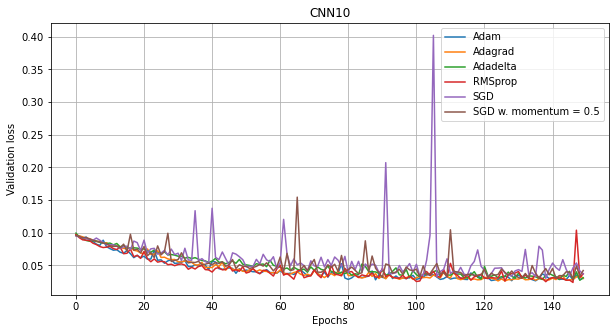

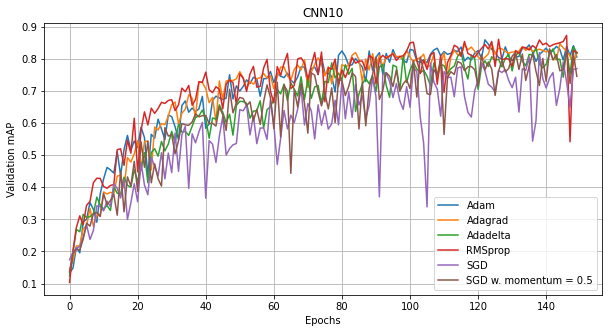

In [44]:
plt.figure(figsize=(10, 5))
plt.plot(adam_val_curves[0], label="Adam")
plt.plot(adagrad_val_curves[0], label="Adagrad")
plt.plot(adadelta_val_curves[0], label="Adadelta")
plt.plot(rmsprop_val_curves[0], label="RMSprop")
plt.plot(sgd_val_curves[0], label="SGD")
plt.plot(sgd05_val_curves[0], label="SGD w. momentum = %.1f" % 0.5)
plt.title("CNN10")
plt.ylabel("Validation loss")
plt.xlabel("Epochs")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(adam_val_curves[1], label="Adam")
plt.plot(adagrad_val_curves[1], label="Adagrad")
plt.plot(adadelta_val_curves[1], label="Adadelta")
plt.plot(rmsprop_val_curves[1], label="RMSprop")
plt.plot(sgd_val_curves[1], label="SGD")
plt.plot(sgd05_val_curves[1], label="SGD w. momentum = %.1f" % 0.5)
plt.title("CNN10")
plt.ylabel("Validation mAP")
plt.xlabel("Epochs")
plt.legend()
plt.grid()
plt.show()

In [81]:
print("SGD :: Best epoch = %d; lr = %.4f" %
      (np.argmax(np.array(sgd_val_curves[1]))+1, sgd_params[0]))
print("SGD w. momentum :: Best epoch = %d; lr = %.4f" %
      (np.argmax(np.array(sgd05_val_curves[1]))+1, sgd05_params[0]))
print("Adagrad :: Best epoch = %d; lr = %.4f" %
      (np.argmax(np.array(adagrad_val_curves[1]))+1, adagrad_params[0]))
print("Adadelta :: Best epoch = %d; lr = %.4f" %
      (np.argmax(np.array(adadelta_val_curves[1]))+1, adadelta_params[0]))
print("RMSprop :: Best epoch = %d; lr = %.4f" %
      (np.argmax(np.array(rmsprop_val_curves[1]))+1, rmsprop_params[0]))
print("Adam :: Best epoch = %d; lr = %.4f" %
      (np.argmax(np.array(adam_val_curves[1]))+1, adam_params[0]))

SGD :: Best epoch = 139; lr = 0.5000
SGD w. momentum :: Best epoch = 142; lr = 0.5000
Adagrad :: Best epoch = 125; lr = 0.0020
Adadelta :: Best epoch = 149; lr = 0.4000
RMSprop :: Best epoch = 147; lr = 0.0001
Adam :: Best epoch = 123; lr = 0.0005


In [169]:
print("SGD :: Best mAP = %.4f" % evaluate(sgd_model))
print("SGD w. momentum :: Best mAP = %.4f" % evaluate(sgd05_model))
print("Adagrad :: Best mAP = %.4f" % evaluate(adagrad_model))
print("Adadelta :: Best mAP = %.4f" % evaluate(adadelta_model))
print("RMSprop :: Best mAP = %.4f" % evaluate(rmsprop_model))
print("Adam :: Best mAP = %.4f" % evaluate(adam_model))

SGD :: Best mAP = 0.7764
SGD w. momentum :: Best mAP = 0.8307
Adagrad :: Best mAP = 0.8126
Adadelta :: Best mAP = 0.8286
RMSprop :: Best mAP = 0.8427
Adam :: Best mAP = 0.8128


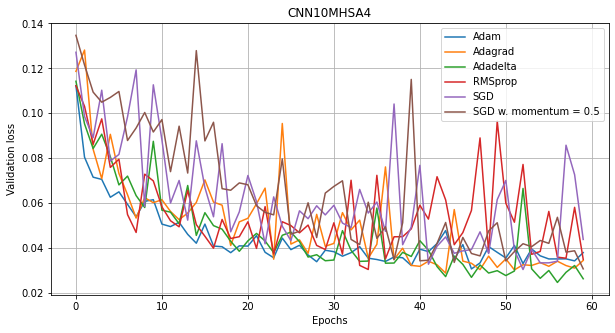

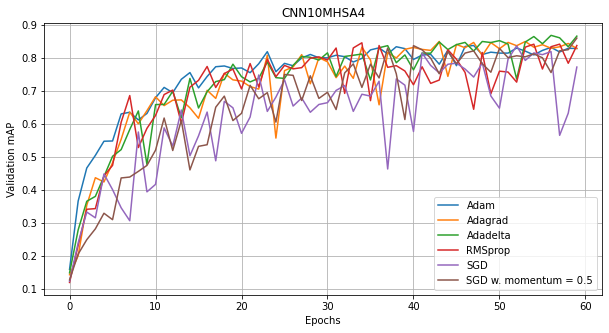

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(adam_val_curves_transformer[0], label="Adam")
plt.plot(adagrad_val_curves_transformer[0], label="Adagrad")
plt.plot(adadelta_val_curves_transformer[0], label="Adadelta")
plt.plot(rmsprop_val_curves_transformer[0], label="RMSprop")
plt.plot(sgd_val_curves_transformer[0], label="SGD")
plt.plot(sgd05_val_curves_transformer[0], label="SGD w. momentum = %.1f" % 0.5)
plt.title("CNN10MHSA4")
plt.ylabel("Validation loss")
plt.xlabel("Epochs")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(adam_val_curves_transformer[1], label="Adam")
plt.plot(adagrad_val_curves_transformer[1], label="Adagrad")
plt.plot(adadelta_val_curves_transformer[1], label="Adadelta")
plt.plot(rmsprop_val_curves_transformer[1], label="RMSprop")
plt.plot(sgd_val_curves_transformer[1], label="SGD")
plt.plot(sgd05_val_curves_transformer[1], label="SGD w. momentum = %.1f" % 0.5)
plt.title("CNN10MHSA4")
plt.ylabel("Validation mAP")
plt.xlabel("Epochs")
plt.legend()
plt.grid()
plt.show()

In [82]:
print("SGD :: Best epoch = %d; lr = %.4f" %
      (np.argmax(np.array(sgd_val_curves_transformer[1]))+1, sgd_params_transformer[0]))
print("SGD w. momentum :: Best epoch = %d; lr = %.4f" %
      (np.argmax(np.array(sgd05_val_curves_transformer[1]))+1, sgd05_params_transformer[0]))
print("Adagrad :: Best epoch = %d; lr = %.4f" %
      (np.argmax(np.array(adagrad_val_curves_transformer[1]))+1, adagrad_params_transformer[0]))
print("Adadelta :: Best epoch = %d; lr = %.4f" %
      (np.argmax(np.array(adadelta_val_curves_transformer[1]))+1, adadelta_params_transformer[0]))
print("RMSprop :: Best epoch = %d; lr = %.4f" %
      (np.argmax(np.array(rmsprop_val_curves_transformer[1]))+1, rmsprop_params_transformer[0]))
print("Adam :: Best epoch = %d; lr = %.4f" %
      (np.argmax(np.array(adam_val_curves_transformer[1]))+1, adam_params_transformer[0]))

SGD :: Best epoch = 53; lr = 0.1000
SGD w. momentum :: Best epoch = 60; lr = 0.3000
Adagrad :: Best epoch = 44; lr = 0.0010
Adadelta :: Best epoch = 57; lr = 0.3500
RMSprop :: Best epoch = 35; lr = 0.0001
Adam :: Best epoch = 48; lr = 0.0001


In [170]:
print("SGD :: Best mAP = %.4f" % evaluate(sgd_model_transformer))
print("SGD w. momentum :: Best mAP = %.4f" % evaluate(sgd05_model_transformer))
print("Adagrad :: Best mAP = %.4f" % evaluate(adagrad_model_transformer))
print("Adadelta :: Best mAP = %.4f" % evaluate(adadelta_model_transformer))
print("RMSprop :: Best mAP = %.4f" % evaluate(rmsprop_model_transformer))
print("Adam :: Best mAP = %.4f" % evaluate(adam_model_transformer))

SGD :: Best mAP = 0.8114
SGD w. momentum :: Best mAP = 0.8542
Adagrad :: Best mAP = 0.8538
Adadelta :: Best mAP = 0.8707
RMSprop :: Best mAP = 0.8142
Adam :: Best mAP = 0.8454


In [174]:
model = adadelta_model
a =sum(p.numel() for p in model.parameters())
model = adadelta_model_transformer
b =sum(p.numel() for p in model.parameters())
print(a,b,a-b,b/a)

4974578 13124082 -8149504 2.6382302177189705


In [166]:
def evaluate(model):
    model.eval()
    with torch.no_grad():
        true = []
        preds = []
        cats = []
        ycats = []
        running_accuracy = 0
        for audios, targets in iter(TEST_LOADER):
            audios = audios.to(DEVICE)
            targets = targets.numpy()[0]

            outputs = model(audios)[0].detach().cpu().numpy()

            true.append(targets)
            preds.append(outputs)

    true = np.array(true).reshape(len(CATEGORIES), -1).T
    preds = np.array(preds).reshape(len(CATEGORIES), -1).T
    score = average_precision_score(true, preds)
    return np.round(score, 4)

In [ ]:
iterator = iter(TEST_LOADER)

In [ ]:
with torch.no_grad():
    x, y = next(iterator)
    plot_spectrogram(x[0][0], y[0])

    p = model.module(x)
    p = torch.where(p >= threshold, 1, 0)
    p = p.detach().numpy()[0]
    y = y.numpy()[0]

    print(get_category(p))